In [547]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import compare
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

## 1. Data Preparation 

In [548]:
##### Data preparation #####
# Load MATLAB data file
data = loadmat('main.mat')

# Extract variables
ulc = data['ulc']
tt2b = data['tt2b']
tn2b = data['tn2b']
p = data['p']  

# Adjusted indices 
country_indices = [1, 3, 4, 6]  # For Germany, Spain, France, Italy in large data sets
country_indices_2 = [1, 2, 3, 5] # For Germany, Spain, France, Italy in smaller data sets

# Filter data for the selected countries
ulc_filtered = ulc[:, country_indices]
tt2b_filtered = tt2b[:, country_indices_2]
tn2b_filtered = tn2b[:, country_indices_2]
p_filtered = p[:, country_indices]

# Create labels
countries = ['Germany', 'Spain', 'France', 'Italy']
years = list(range(1995, 2008))  # 2007 inclusive
years_num = list(range(1995, 2008))  # 2007 inclusive

# Convert to DataFrames
ulc_df = pd.DataFrame(ulc_filtered, columns=countries, index=years)
tt2b_df = pd.DataFrame(-tt2b_filtered, columns=countries, index=years) # negate
tn2b_df = pd.DataFrame(-tn2b_filtered, columns=countries, index=years) # negate

# Convert DataFrames to arrays for computation if needed
ulc_array = ulc_df.to_numpy()
tt2b_array = tt2b_df.to_numpy()
tn2b_array = tn2b_df.to_numpy()

#transform ucl variable
rucl_array = -np.log(ulc_array) # negate
rucl_df = pd.DataFrame(rucl_array, index=years, columns=countries)

# Negate each element in p_filtered
p_negated_array = -p_filtered 

# Convert the negated array back to a DataFrame with proper labels
q_real_df = pd.DataFrame(p_negated_array, columns=countries, index=years) # these are the real exchange rates from actual data

# Calculate the mean of each variable across years for each country
mean_rucl = rucl_df.mean()
mean_tt2b = tt2b_df.mean()
mean_tn2b = tn2b_df.mean()
mean_q = q_real_df.mean()

# Create a DataFrame to store the means, with countries as the index
means_df = pd.DataFrame({
    'mean of rucl': mean_rucl,
    'mean of a_T': mean_tt2b,
    'mean of a_N': mean_tn2b,
    'mean of q' : mean_q
})

# Transpose the DataFrame so that countries become rows and variables become columns
means_df = means_df.T

means_df_transposed = means_df.T # depends on what should be columns and what rows 
print(means_df_transposed) # these now correspond to the means in p.1561 --> defined as Eu average relative to home 


         mean of rucl  mean of a_T  mean of a_N  mean of q
Germany     -0.133066    -0.018930    -0.077726  -0.014296
Spain        0.056322     0.119346    -0.024505   0.172924
France      -0.053314    -0.009212    -0.068875  -0.026378
Italy       -0.015665     0.027495     0.102903   0.053580


## 2. Equation (6)

### 2.1 Exchnage rates relative to Eu average

In [549]:
# Apply equation (6)
q_array_13 = 0.7 * (rucl_array) + 0.21 * (tt2b_array) - 0.21 * (tn2b_array)

# Convert the result back to a DataFrame with proper labels
q_13_df = pd.DataFrame(q_array_13, index=years, columns=countries) #these are the real exchnage rates using equation (13) from original paper

Visualisation of actual vs. real exchange rate relative to Eu average 

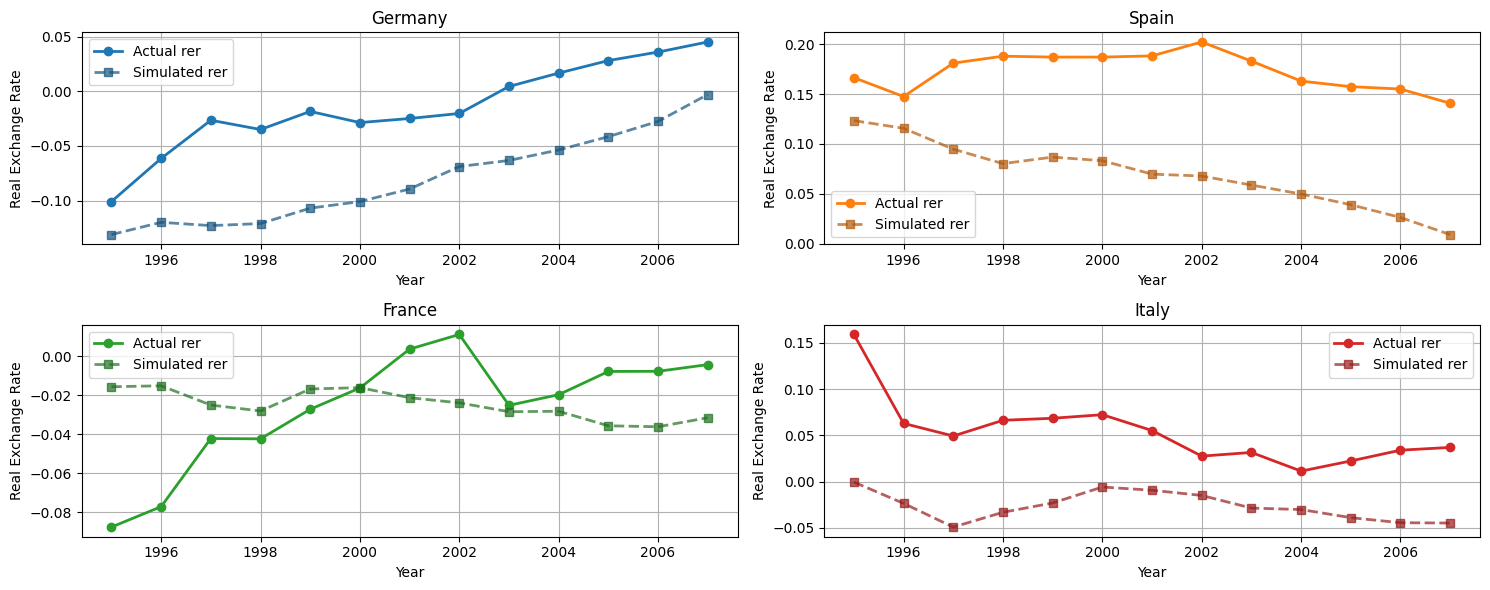

In [550]:
## Visualisation of aggregate real exchnage rates ##

# Years for the x-axis
years_numeric = list(range(1995, 2008))


# Define colors for actual and simulated data for distinction
colors = plt.cm.tab10(range(len(countries)))  
actualColors = colors  # Use for actual data
simulatedColors = colors * 0.7  # Darken the colors for simulated data to distinguish

# Loop through each country to create subplots
fig1, axs = plt.subplots(2, 2, figsize=(15, 6))  
axs = axs.flatten()  # Flatten to access axes in a loop

for i, country in enumerate(countries):
    axs[i].plot(years_numeric, q_real_df[country], '-o', color=actualColors[i], linewidth=2, markersize=6, label='Actual rer')
    axs[i].plot(years_numeric, q_13_df[country], '--s', color=simulatedColors[i], linewidth=2, markersize=6, label='Simulated rer')
    axs[i].set_title( country)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Real Exchange Rate')
    axs[i].legend(loc='best')
    axs[i].grid(True)
    
plt.tight_layout()
#fig1.suptitle('Actual vs. Simulated Real Exchange Rates as EU average realtive to home country', fontsize=16, y=1.02)
plt.show()
fig1.savefig('figure_1.pdf', dpi=200)


Bar chart visualisation

In [551]:
# Disected Visualisation 
# Defining 

simulated_exchange_rate = {
    country: q_13_df[country]
    for country in q_13_df.columns
}

# Calculate the contributions for each country
components_df = {}

for country in countries:
    # Calculate each component's contribution
    RULC_contribution = 0.7 * (rucl_df[country])
    traded_goods_contribution = 0.21 * (tt2b_df[country])  # Assuming 'Foreign' is a placeholder for foreign productivity
    non_traded_goods_contribution = -0.21 * (tn2b_df[country])  # Similarly for non-traded goods

    # Combine contributions into a DataFrame
    components_df[country] = pd.DataFrame({
        'rulc': RULC_contribution,
        'tfp_T': traded_goods_contribution,
        'tfp_N': non_traded_goods_contribution
    }, index=rucl_df.index)



In [552]:
# Set consistent colors for each variable
variables = ['rulc', 'tfp_T', 'tfp_N']
colors = {'rulc': 'blue', 'tfp_T': 'orange', 'tfp_N': 'green'}

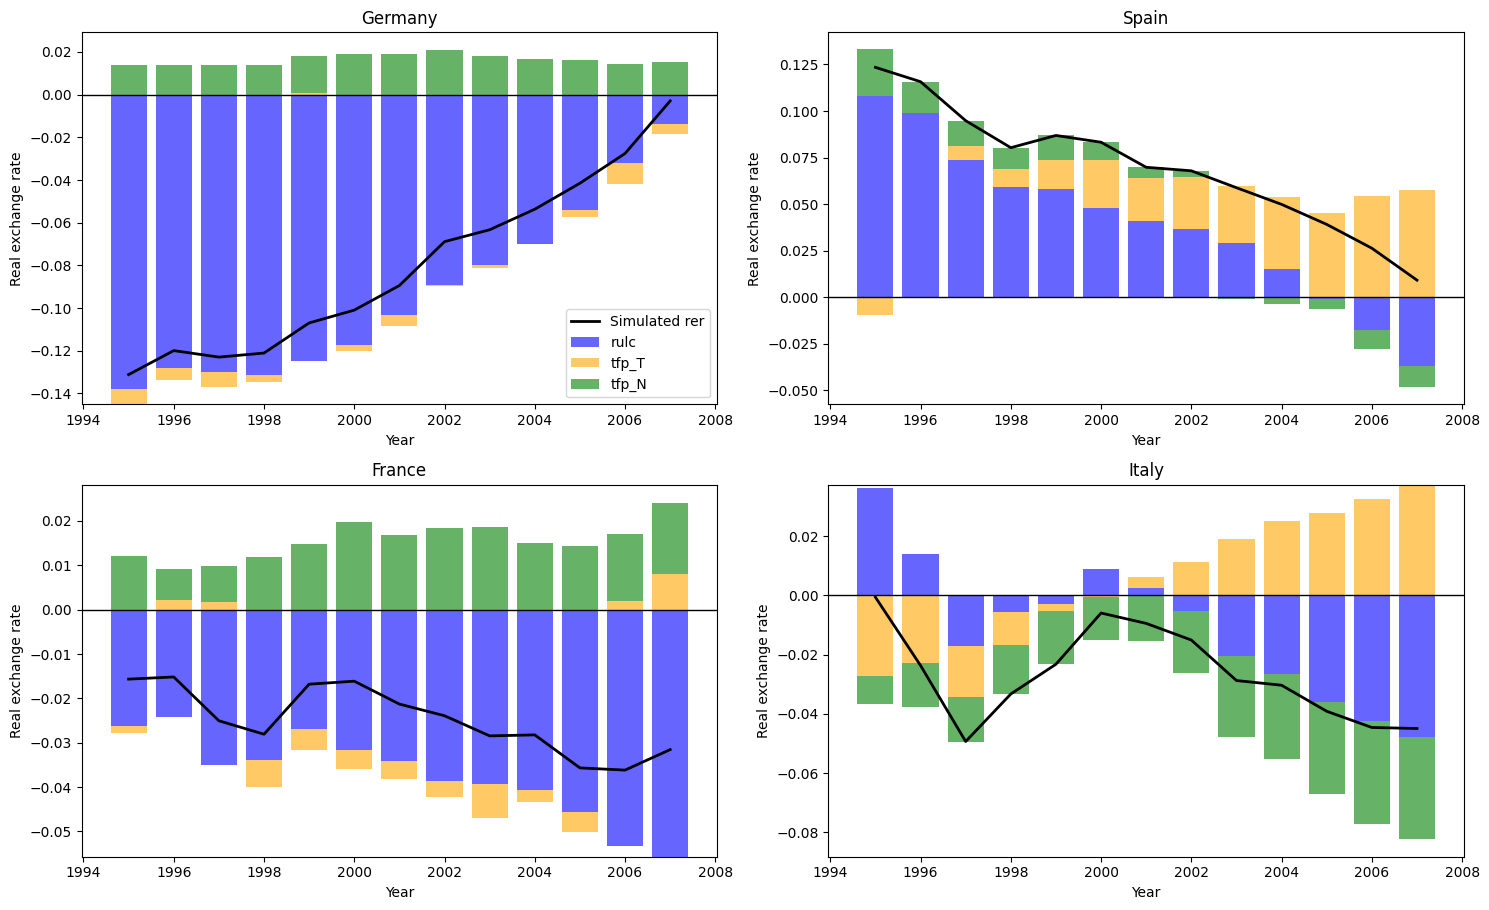

In [553]:
fig2, axs = plt.subplots(2, 2, figsize=(15, 10))  # Create a 2x2 grid of subplots
axs = axs.flatten()  # Flatten to access in loop

# Loop through countries and plot data
for i, country in enumerate(countries):
    # Make sure the country is a key in the dictionary
    if country in components_df:
        df = components_df[country]  # Get the DataFrame for the country
        bars_pos = np.maximum(df, 0)  # Calculate the positive part of the bars
        bars_neg = np.minimum(df, 0)  # Calculate the negative part of the bars
        bottoms_pos = np.zeros(len(df))  # Initialize bottoms for positive bars
        bottoms_neg = np.zeros(len(df))  # Initialize bottoms for negative bars
        
        # Plot positive bars
        for v in variables:
            if i == 0:  # Only add labels for the first country
                axs[i].bar(df.index, bars_pos[v], bottom=bottoms_pos, color=colors[v], label=v, alpha=0.6)
            else:
                axs[i].bar(df.index, bars_pos[v], bottom=bottoms_pos, color=colors[v], alpha=0.6)
            bottoms_pos += bars_pos[v].values  # Update bottoms for stacking

        # Plot negative bars
        for v in variables:
            axs[i].bar(df.index, bars_neg[v], bottom=bottoms_neg, color=colors[v], alpha=0.6)
            bottoms_neg += bars_neg[v].values
        
        # Plot simulated exchange rate
        axs[i].plot(components_df[country].index, q_13_df[country], c='black', label='Simulated rer' if i == 0 else "", ls='-', lw=2)

        # Set titles and labels
        axs[i].set_title(country)
        axs[i].set_xlabel('Year')
        axs[i].set_ylabel('Real exchange rate')
        axs[i].axhline(y=0, color="black", linewidth=1)

        # Add legend to the first subplot
        if i == 0:
            axs[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
#plt.suptitle('Variable Contributions to Simulated Exchange Rate by Country', fontsize=16)
plt.show()

fig2.savefig('figure_2.pdf', dpi=200)


Percentage Change Plot and Correlation

In [554]:
# Correlarion 
# Calculating the correlation for each pair
correlation_g = np.corrcoef(q_real_df['Germany'], q_13_df['Germany'])[0, 1]
correlation_s = np.corrcoef(q_real_df['Spain'], q_13_df['Spain'])[0, 1]
correlation_f = np.corrcoef(q_real_df['France'], q_13_df['France'])[0, 1]
correlation_i = np.corrcoef(q_real_df['Italy'], q_13_df['Italy'])[0, 1]


# Creating a DataFrame to display the correlations in a table
correlation_table_1 = pd.DataFrame({
    'Country': ['Germany', 'Spain', 'France', 'Italy'],
    'Correlation': [correlation_g, correlation_s, correlation_f, correlation_i]
})

# Print the correlation table
print(correlation_table_1) 

# save to latex 
correlation_table_1 = correlation_table_1.to_latex(index=False, label="tab:correlation")
with open('corr_table_1.tex', 'w') as f:
    f.write(correlation_table_1)


   Country  Correlation
0  Germany     0.903361
1    Spain     0.334041
2   France    -0.519060
3    Italy     0.601674


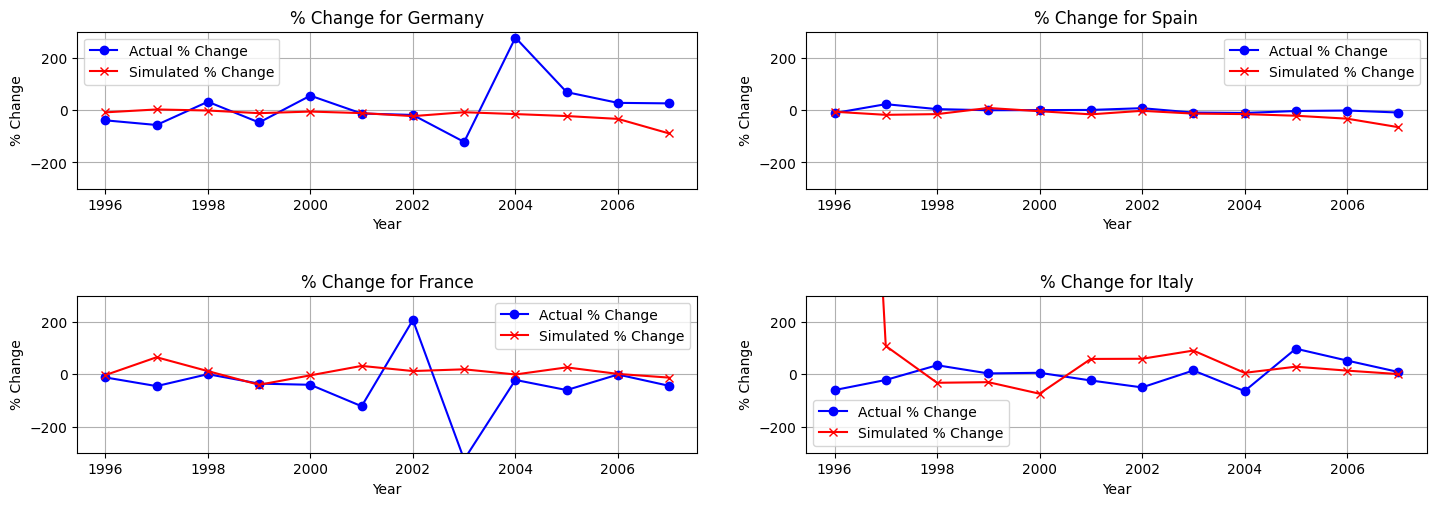

In [555]:
# Percentage Change plot
# Calculating percent change for actual and simulated data
actual_percent_change = q_real_df.pct_change()
simulated_percent_change = q_13_df.pct_change()

# Plotting percent change for actual vs simulated data
fig3, axs = plt.subplots(2, 2, figsize=(15, 6))
axs = axs.flatten()

for i, country in enumerate(countries):
    # Actual data percent change plot
    axs[i].plot(actual_percent_change.index, actual_percent_change[country]*100, '-o', label='Actual % Change', color='blue')
    
    # Simulated data percent change plot
    axs[i].plot(simulated_percent_change.index, simulated_percent_change[country]*100, '-x', label='Simulated % Change', color='red')
    
    axs[i].set_title(f'% Change for {country}')
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('% Change')
    axs[i].set_ylim(-300,300)
    axs[i].legend()
    axs[i].grid(True)
    
plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0, rect=[0, 0, 1, 0.95])
#fig3.suptitle("Figure 2: Actual vs. Simulated Percentage Changes in Real Exchange rates relative to EU15")
plt.show()

fig3.savefig('figure_3.pdf')

In [556]:
#higher fluctuations in the actual data than predicted by the equation, (See paper)

Regression Analysis

In [557]:
# Reshape your dependent variable to match.
Y = q_real_df.stack().values

# Prepare data for analysis
data_dict = {
    'tfp_T': tt2b_array.flatten(),
    'tfp_N': tn2b_array.flatten(),
    'rulc': rucl_array.flatten()
}
X_13 = pd.DataFrame(data_dict)

# Add a constant term to the independent variables for the intercept.
X_13 = sm.add_constant(X_13)

# Fit the OLS model.
model1 = sm.OLS(Y, X_13).fit()

# Print the summary.
print(model1.summary())  # We can read from the summary table that relative unit labor costs provide the most significant impact

# Get the regression summary as LaTeX code
latex_summary = model1.summary().as_latex()

# Write the LaTeX summary to a file
with open('reg_table_1.tex', 'w') as f:
    f.write(latex_summary)


#the signs of the coefficients now correspond to those of the paper --> It makes sense since variables are defined as EU average relative to home country

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     45.93
Date:                Sun, 19 May 2024   Prob (F-statistic):           3.81e-14
Time:                        18:15:57   Log-Likelihood:                 89.520
No. Observations:                  52   AIC:                            -171.0
Df Residuals:                      48   BIC:                            -163.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0627      0.008      8.176      0.0

In [558]:
# Standardizing the variables excluding the intercept
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_13.iloc[:, 1:])  # Exclude the constant term for standardization
X_scaled = sm.add_constant(X_scaled)  # Re-add the constant term after standardization

# Fit the OLS model with standardized variables
model_standardized = sm.OLS(Y, X_scaled).fit()

# Extract and print the coefficients for each variable excluding the intercept
coefficients = model_standardized.params[1:]  # Skip the intercept
variable_names = ['Productivity Traded Sector', 'Productivity Non-Traded Sector', 'Relative Unit Labor Costs']

print("\nCoefficients:")
for idx, col_name in enumerate(variable_names):
    print(f"{col_name}: {coefficients[idx]:.3f}")

# Prepare data for LaTeX output
data = {
    'Variable': variable_names,
    'Coefficient': coefficients
}
coefficients_df = pd.DataFrame(data)

# Convert the DataFrame to a LaTeX string
coefficients_latex = coefficients_df.to_latex(index=False, caption="Regression Coefficients", label="tab:regression_coeffs")

# Write the LaTeX string to a file
with open('stand_coef_1.tex', 'w') as f:
    f.write(coefficients_latex)



Coefficients:
Productivity Traded Sector: 0.031
Productivity Non-Traded Sector: -0.007
Relative Unit Labor Costs: 0.063


In [559]:
# Panel regression 
# Prepare the data for Panel Analysis
# Let's create a MultiIndex for the panel data structure
multi_index = pd.MultiIndex.from_product([countries, years_numeric], names=['country', 'year'])
panel_df = pd.DataFrame(index=multi_index)

# Unstack your dataframes to have years as columns for each country, then stack them back with multi-level index
rulc_panel = rucl_df.unstack().reindex(panel_df.index)
tt2b_panel = tt2b_df.unstack().reindex(panel_df.index)
tn2b_panel = tn2b_df.unstack().reindex(panel_df.index)
q_real_panel = q_real_df.unstack().reindex(panel_df.index)

# Convert unstacked DataFrame back to stacked format and add to panel_df
panel_df['rulc'] = rulc_panel
panel_df['tfp_T'] = tt2b_panel
panel_df['tfp_N'] = tn2b_panel
panel_df['Q_Real'] = q_real_panel

# Convert panel_df to a PanelData format expected by linearmodels
panel_df = panel_df.reset_index()
panel_df = panel_df.set_index(['country', 'year'])

# Running Fixed Effects model
fe_model = PanelOLS.from_formula('Q_Real ~ tfp_T + tfp_N + rulc + EntityEffects', data=panel_df)
fe_results = fe_model.fit()

print(fe_results)

# Get the regression summary as LaTeX code
latex_summary_2 = fe_results.summary.as_latex()

# Write the LaTeX summary to a file
with open('reg_table_2.tex', 'w') as f:
    f.write(latex_summary_2)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 Q_Real   R-squared:                        0.3079
Estimator:                   PanelOLS   R-squared (Between):              0.2491
No. Observations:                  52   R-squared (Within):               0.3079
Date:                Sun, May 19 2024   R-squared (Overall):              0.2552
Time:                        18:15:57   Log-likelihood                    115.81
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.6723
Entities:                           4   P-value                           0.0008
Avg Obs:                       13.000   Distribution:                    F(3,45)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             6.6723
                            

### 2.2 Bilateral Exchange rates relative to Germany

Visualisation of simulated vs actual exchnage rate

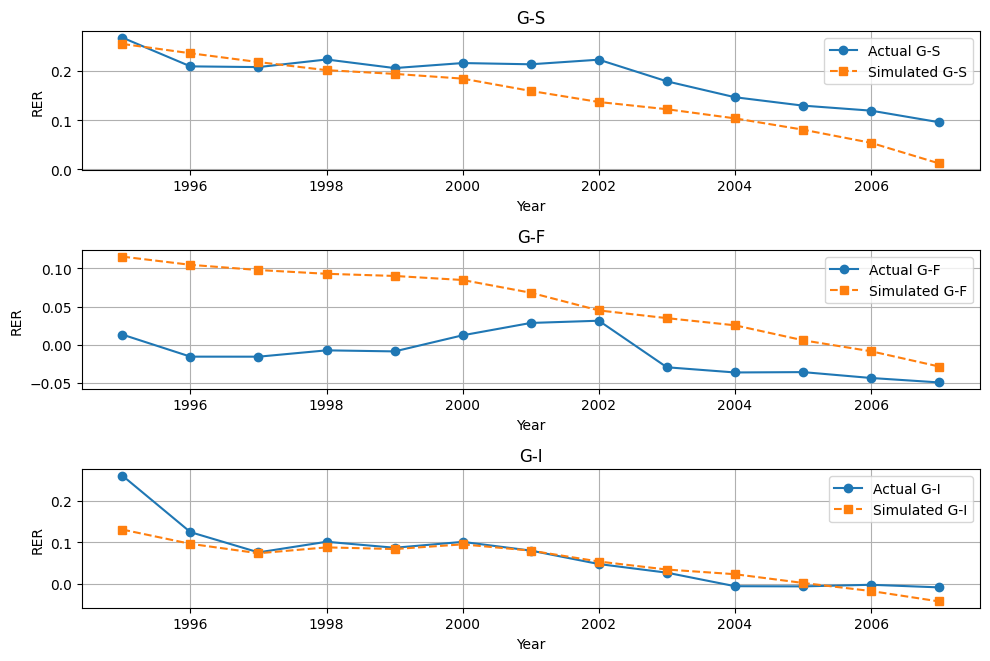

In [560]:
##### Bilateral real exchnage rates ######
# from data 
bilat_rate_germany_spain = q_real_df['Spain'] - q_real_df['Germany']
bilat_rate_germany_france = q_real_df['France'] - q_real_df['Germany']
bilat_rate_germany_italy = q_real_df['Italy'] - q_real_df['Germany'] # order of countries?!

#define again for later purposes --> makes sense for later code 
bilat_rate_gs = q_real_df['Spain'] - q_real_df['Germany']
bilat_rate_gf = q_real_df['France'] - q_real_df['Germany']
bilat_rate_gi = q_real_df['Italy'] - q_real_df['Germany']

# from equation 
# Parameters
gamma = 0.5
kappa = 0.6
omgk = 1 - gamma * kappa  # one_minus_gamma_kappa
gk = gamma * kappa  # gamma_kappa

# Calculating simulated bilateral exchange rates using equation (13)
q_sg = omgk * (rucl_df['Spain'] -rucl_df['Germany']) + omgk * gk * (tt2b_df['Spain'] - tt2b_df['Germany']) - omgk * gk * (tn2b_df['Spain'] - tn2b_df['Germany'])
q_fg = omgk * (rucl_df['France'] -rucl_df['Germany']) + omgk * gk * (tt2b_df['France'] - tt2b_df['Germany']) - omgk * gk * (tn2b_df['France'] - tn2b_df['Germany'])
q_ig = omgk * (rucl_df['Italy'] -rucl_df['Germany']) + omgk * gk * (tt2b_df['Italy'] - tt2b_df['Germany']) - omgk * gk * (tn2b_df['Italy'] - tn2b_df['Germany'])

# Define a list of tuples containing actual and simulated data with their labels
bilat_data = [
    (bilat_rate_germany_spain, q_sg, 'G-S'),
    (bilat_rate_germany_france, q_fg, 'G-F'),
    (bilat_rate_germany_italy, q_ig, 'G-I')
]

# Initialize the figure
fig4, axs = plt.subplots(len(bilat_data), 1, figsize=(10, 7))

# Loop over each bilateral rate data
for i, (actual_rate, simulated_rate, label) in enumerate(bilat_data):
    axs[i].plot(years_numeric, actual_rate, '-o', label=f'Actual {label}')
    axs[i].plot(years_numeric, simulated_rate, '--s', label=f'Simulated {label}')
    axs[i].set_title(label)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('RER')
    axs[i].legend()
    axs[i].grid(True)

# Set a common title and adjust layout
#fig4.suptitle('Figure 3: Actual vs. Simulated Bilateral Real Exchange Rates', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig4.savefig('figure_4.pdf', dpi=200)


Bar chart visualisation

In [561]:
# Disected Visualization: Bar plot 
# Defining 
variables = ['rulc', 'tfp_T', 'tfp_N']
# Calculate the contributions for each country
components_bilat_df = {}

for country in countries:
    # Calculate each component's contribution
    RULC_contribution_bilat = 0.7 * (rucl_df[country]-rucl_df['Germany'])
    traded_goods_contribution_bilat = 0.21 * (tt2b_df[country]- tt2b_df['Germany'])  
    non_traded_goods_contribution_bilat = -0.21 * (tn2b_df[country]- tn2b_df['Germany'])  

    # Combine contributions into a DataFrame
    components_bilat_df[country] = pd.DataFrame({
        'rulc': RULC_contribution_bilat,
        'tfp_T': traded_goods_contribution_bilat,
        'tfp_N': non_traded_goods_contribution_bilat
    }, index=rucl_df.index)

# Remove 'Germany' from the dictionary if it exists
if 'Germany' in components_bilat_df:
    del components_bilat_df['Germany']

#print(components_bilat_df)

country_pairs = ['Spain', 'France', 'Italy']


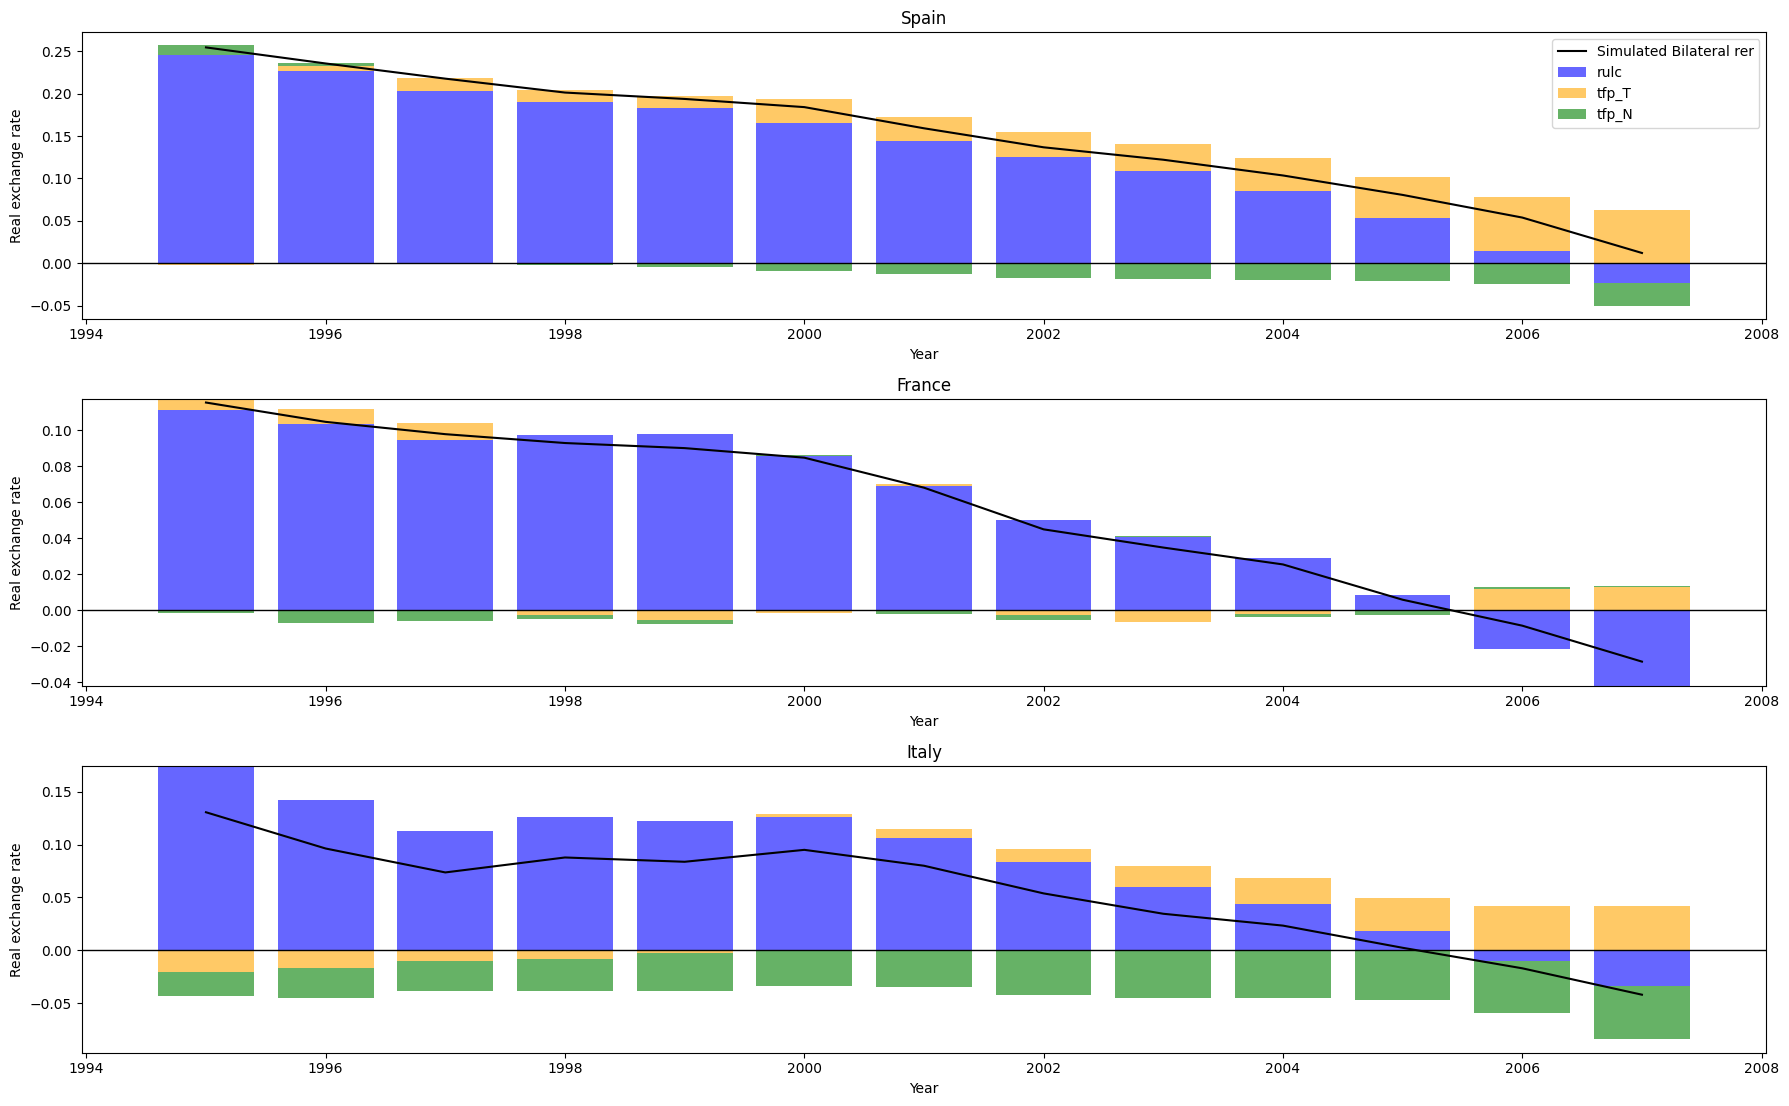

In [562]:
fig5, axs = plt.subplots(3, 1, figsize=(18, 12))  
axs = axs.flatten()  

colors = {'rulc': 'blue', 'tfp_T': 'orange', 'tfp_N': 'green'}
country_pair = ['Germany - Spain', 'Germany - France', 'Germany - Italy']

# Loop through countries and variables to create the plots
for i, country in enumerate(country_pairs):
    bars_pos = np.maximum(components_bilat_df[country], 0)
    bars_neg = np.minimum(components_bilat_df[country], 0)

    bottoms_pos = np.zeros_like(bars_pos['rulc'])
    bottoms_neg = np.zeros_like(bars_neg['rulc'])

    # Plot positive and negative components
    for v in variables:
        axs[i].bar(components_bilat_df[country].index, bars_pos[v], bottom=bottoms_pos,
                   color=colors[v], alpha=0.6, label=v if i == 0 else None)  # Add labels only for the first subplot
        bottoms_pos += bars_pos[v]

        axs[i].bar(components_bilat_df[country].index, bars_neg[v], bottom=bottoms_neg,
                   color=colors[v], alpha=0.6)
        bottoms_neg += bars_neg[v]

# Add simulated and real bilateral RER
simulated_bilat_rer = [q_sg, q_fg, q_ig]
real_bilat_rer = [bilat_rate_gs, bilat_rate_gf, bilat_rate_gi]

for i, country in enumerate(country_pairs):
    axs[i].plot(components_bilat_df[country].index, simulated_bilat_rer[i],
                'k-', label='Simulated Bilateral rer' if i == 0 else None)  # Label only the first occurrence
    #axs[i].plot(components_bilat_df[country].index, real_bilat_rer[i],
                #'k--', label='Actual Bilateral rer' if i == 0 else None)  # Label only the first occurrence

    axs[i].set_title(country)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Real exchange rate')
    axs[i].axhline(y=0, color="black", linewidth=1)

    # Add legend to the first subplot only to avoid duplication
    if i == 0:
        axs[i].legend()

# Adjust layout and set a common title
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
#plt.suptitle('Figure 4: Variable Contributions to Simulated Exchange', fontsize=16)

# Show the plot
plt.show()

fig5.savefig('figure_5.pdf', dpi=200)

Percentage Change plot

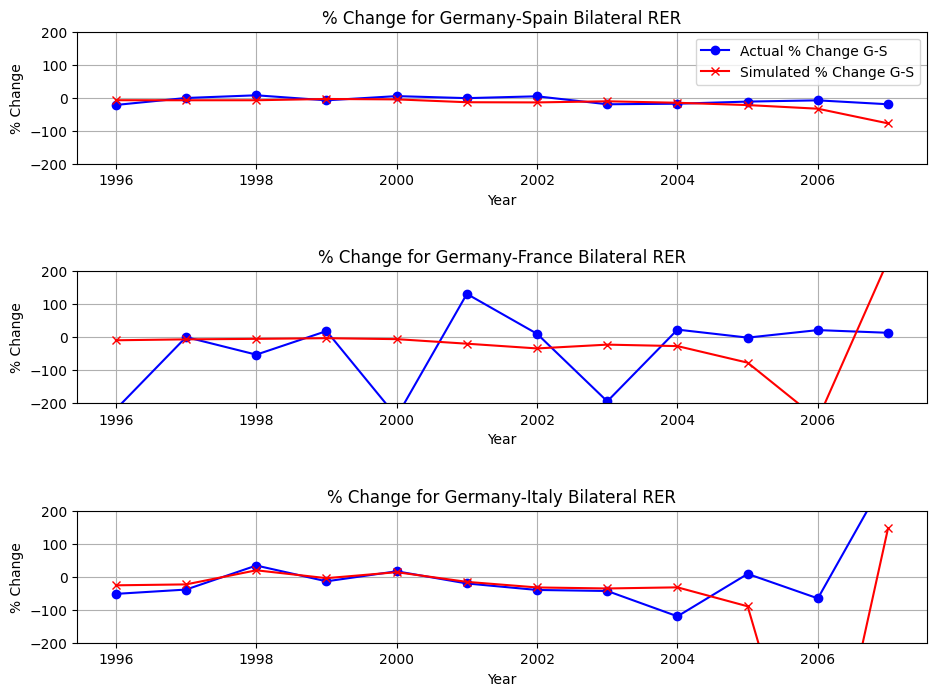

In [563]:
# Percentage Change Plots
# Calculate Percentage change
actual_bilat_percent_change_gs = bilat_rate_germany_spain.pct_change().dropna()
simulated_bilat_percent_change_gs = q_sg.pct_change().dropna()

actual_bilat_percent_change_gf = bilat_rate_germany_france.pct_change().dropna()
simulated_bilat_percent_change_gf = q_fg.pct_change().dropna()

actual_bilat_percent_change_gi = bilat_rate_germany_italy.pct_change().dropna()
simulated_bilat_percent_change_gi = q_ig.pct_change().dropna()
# Plotting percent change for actual vs simulated data for each country pair
fig6, axs = plt.subplots(3, 1, figsize=(10, 8))
years = list(range(1996, 2008))  # Start from 1996 because the first year will be dropped due to pct_change()

# Germany-Spain
axs[0].plot(years, actual_bilat_percent_change_gs * 100, '-o', label='Actual % Change G-S', color='blue')
axs[0].plot(years, simulated_bilat_percent_change_gs * 100, '-x', label='Simulated % Change G-S', color='red')
axs[0].set_title('% Change for Germany-Spain Bilateral RER')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('% Change')
axs[0].set_ylim(-200, 200),
axs[0].legend()
axs[0].grid(True)

# Germany-France
axs[1].plot(years, actual_bilat_percent_change_gf * 100, '-o', label='Actual % Change G-F', color='blue')
axs[1].plot(years, simulated_bilat_percent_change_gf * 100, '-x', label='Simulated % Change G-F', color='red')
axs[1].set_title('% Change for Germany-France Bilateral RER')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('% Change')
axs[1].set_ylim(-200, 200),
axs[1].grid(True)

# Germany-Italy
axs[2].plot(years, actual_bilat_percent_change_gi * 100, '-o', label='Actual % Change G-I', color='blue')
axs[2].plot(years, simulated_bilat_percent_change_gi * 100, '-x', label='Simulated % Change G-I', color='red')
axs[2].set_title('% Change for Germany-Italy Bilateral RER')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('% Change')
axs[2].set_ylim(-200, 200),
axs[2].grid(True)

plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0, rect=[0, 0, 1, 0.95])
#fig6.suptitle("Figure 4: Actual vs. Simulated Percentage Changes in Bilateral Real Exchange rates")
plt.show()

fig6.savefig('figure_6.pdf')


Correlation coefficients

In [564]:
# Correlation Analysis 
# Calculating the correlation for each pair
correlation_gs = np.corrcoef(bilat_rate_germany_spain, q_sg)[0, 1]
correlation_gf = np.corrcoef(bilat_rate_germany_france, q_fg)[0, 1]
correlation_gi = np.corrcoef(bilat_rate_germany_italy, q_ig)[0, 1]

# Creating a DataFrame to display the correlations in a table
correlation_table = pd.DataFrame({
    'Country Pair': ['Germany-Spain', 'Germany-France', 'Germany-Italy'],
    'Correlation': [correlation_gs, correlation_gf, correlation_gi]
})

# Print the correlation table
print(correlation_table) 
correlation_table_2 = correlation_table.to_latex(index=False, label="tab:correlation")
with open('corr_table_2.tex', 'w') as f:
    f.write(correlation_table_2)

     Country Pair  Correlation
0   Germany-Spain     0.917851
1  Germany-France     0.638099
2   Germany-Italy     0.880476


Regression Analysis

In [565]:
# Regression Analysis (OLS) for data of all countries 
# + Moderation Term for country

#AV: bilat_rate_germany_spain + italy + france
#UV: Country*rucl_df+tt2b_df+tn2b_df #I decided to removed moderation term


In [566]:
#RUCL
rucl_df["sg"] = rucl_df["Spain"]-rucl_df["Germany"] 
rucl_df["fg"] = rucl_df["France"]-rucl_df["Germany"]
rucl_df["ig"] = rucl_df["Italy"]-rucl_df["Germany"]

#TT2B
tt2b_df["sg"] = tt2b_df["Spain"]-tt2b_df["Germany"]
tt2b_df["fg"] = tt2b_df["France"]-tt2b_df["Germany"]
tt2b_df["ig"] = tt2b_df["Italy"]-tt2b_df["Germany"]

#TN2B
tn2b_df["sg"] = tn2b_df["Spain"]-tn2b_df["Germany"]
tn2b_df["fg"] = tn2b_df["France"]-tn2b_df["Germany"]
tn2b_df["ig"] = tn2b_df["Italy"]-tn2b_df["Germany"]

#Country

bilat_rate_germany_spain = pd.DataFrame(bilat_rate_germany_spain)
bilat_rate_germany_spain["bilat"] = bilat_rate_germany_spain[0]
bilat_rate_germany_spain["country"] = "Spain"


bilat_rate_germany_france = pd.DataFrame(bilat_rate_germany_france)
bilat_rate_germany_france["bilat"] = bilat_rate_germany_france[0]
bilat_rate_germany_france["country"] = "France"

bilat_rate_germany_italy = pd.DataFrame(bilat_rate_germany_italy)
bilat_rate_germany_italy["bilat"] = bilat_rate_germany_italy[0]
bilat_rate_germany_italy["country"] = "Italy"



In [567]:
# Assuming 'fg', 'sg', 'ig' are column names in the respective DataFrames
temp_france = bilat_rate_germany_france.to_frame(name='bilat_rate') if isinstance(bilat_rate_germany_france, pd.Series) else bilat_rate_germany_france.copy()
temp_france["rulc"] = rucl_df["fg"]
temp_france["tfp_T"] = tt2b_df["fg"]
temp_france["tfp_N"] = tn2b_df["fg"]

temp_spain = bilat_rate_germany_spain.to_frame(name='bilat_rate') if isinstance(bilat_rate_germany_spain, pd.Series) else bilat_rate_germany_spain.copy()
temp_spain["rulc"] = rucl_df["sg"]
temp_spain["tfp_T"] = tt2b_df["sg"]
temp_spain["tfp_N"] = tn2b_df["sg"]

temp_italy = bilat_rate_germany_italy.to_frame(name='bilat_rate') if isinstance(bilat_rate_germany_italy, pd.Series) else bilat_rate_germany_italy.copy()
temp_italy["rulc"] = rucl_df["ig"]
temp_italy["tfp_T"] = tt2b_df["ig"]
temp_italy["tfp_N"] = tn2b_df["ig"]

# Concatenate along the default axis (0)
all_countries = pd.concat([temp_france, temp_spain, temp_italy])


# Append all 3 datasets
all_countries = pd.concat([temp_france, temp_spain, temp_italy])

In [568]:
# Prepare the independent variables (add a constant for the intercept)
X = all_countries[['tfp_T', 'tfp_N', 'rulc']]
X = sm.add_constant(X)  # adding a constant

# Prepare the dependent variable
Y = all_countries['bilat']

# Create the OLS model
model = sm.OLS(Y, X)
results_bilat = model.fit()

# Print the summary of the model
print(results_bilat.summary())

# save as latex file
latex_summary_3 = results_bilat.summary().as_latex()
with open('reg_table_3.tex', 'w') as f:
    f.write(latex_summary_3)


                            OLS Regression Results                            
Dep. Variable:                  bilat   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     43.06
Date:                Sun, 19 May 2024   Prob (F-statistic):           7.70e-12
Time:                        18:16:00   Log-Likelihood:                 65.817
No. Observations:                  39   AIC:                            -123.6
Df Residuals:                      35   BIC:                            -117.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0721      0.018     -4.046      0.0

In [569]:

# Standardize the predictors and the dependent variable
scaler = StandardScaler()
all_countries_standardized = pd.DataFrame(scaler.fit_transform(all_countries[['tfp_T', 'tfp_N', 'rulc', 'bilat']]),
                                          columns=['tfp_T', 'tfp_N', 'rulc', 'bilat'])

# Add a constant to the standardized predictors
X_standardized = sm.add_constant(all_countries_standardized[['tfp_T', 'tfp_N', 'rulc']])

# Dependent variable
Y_standardized = all_countries_standardized['bilat']

# Fit the OLS model using standardized variables
model_standardized = sm.OLS(Y_standardized, X_standardized)
results_standardized = model_standardized.fit()

# Extract and print the coefficients for each variable
print("\nCoefficients for Variables:")
variable_names = ['Productivity Traded Sector', 'Productivity Non-Traded Sector', 'Relative Unit Labor Costs']
coefficients_2 = results_standardized.params
for idx, var_name in enumerate(variable_names, start=1):  # Start from 1 to skip the intercept
    print(f"{var_name}: {coefficients_2[idx]:.3f}")

# Save to latex
data2 = {
    'Variable': ['Intercept'] + variable_names,
    'Coefficient': coefficients_2.values
}
coefficients_df_2 = pd.DataFrame(data2)

# Convert the DataFrame to a LaTeX string
coefficients_latex_2 = coefficients_df_2.to_latex(index=False, caption="Regression Coefficients", label="tab:regression_coeffs")

# Write the LaTeX string to a file
with open('stand_coef_2.tex', 'w') as f:
    f.write(coefficients_latex_2)



Coefficients for Variables:
Productivity Traded Sector: 0.475
Productivity Non-Traded Sector: 0.035
Relative Unit Labor Costs: 0.969


/var/folders/4p/pdgzp33540z1z7ghbh4n90xc0000gn/T/ipykernel_12848/2445696634.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{var_name}: {coefficients_2[idx]:.3f}")


In [570]:
# Create a copy of the DataFrame and set the index
all_countries_copy = all_countries.copy()
all_countries_copy.set_index('country', append=True, inplace=True)
all_countries_copy.index.names = ['year', 'country']

# Explicitly convert and set the 'year' part of the MultiIndex to numeric
years_numeric = pd.to_numeric(all_countries_copy.index.get_level_values(0), errors='coerce')
all_countries_copy.index = pd.MultiIndex.from_arrays([years_numeric, all_countries_copy.index.get_level_values(1)], names=['year', 'country'])
all_countries_copy.reset_index(inplace=True)


# drop column
all_countries_copy.rename(columns={0: 'zero'}, inplace=True)
all_countries_copy = all_countries_copy.drop('zero', axis=1, inplace=False)


# Now let's set 'country' and 'year' as the index for panel data, ensuring they are in the correct order
all_countries_copy.set_index(['country', 'year'], inplace=True)

In [571]:
from linearmodels.panel import PanelOLS

# Define and fit the panel regression model with fixed effects
model = PanelOLS.from_formula('bilat ~ tfp_T + tfp_N + rulc + EntityEffects', data=all_countries_copy)
results = model.fit()

# Print the summary of the model
print(results.summary)

# Optionally, save the summary to a LaTeX file if needed
latex_summary = results.summary.as_latex()
with open('reg_table_4.tex', 'w') as file:
    file.write(latex_summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  bilat   R-squared:                        0.7260
Estimator:                   PanelOLS   R-squared (Between):             -0.0661
No. Observations:                  39   R-squared (Within):               0.7260
Date:                Sun, May 19 2024   R-squared (Overall):              0.0674
Time:                        18:16:00   Log-likelihood                    85.306
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      29.139
Entities:                           3   P-value                           0.0000
Avg Obs:                       13.000   Distribution:                    F(3,33)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             29.139
                            

In [572]:
year = [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]

## 3. Equation (8): 

### 3.1 The labor wedge

In [573]:
# Parameters from calibration
gamma = 0.5
kappa = 0.6
sigma = 2
psi = 1
lambda_ = 8  # Use lambda_ instead of lambda because lambda is a reserved keyword in Python

# Compute beta_0, beta_1, and D 
# note: These are not yet the "correct" coefficients
beta_0 = gamma * kappa * ((1 + psi) * sigma + psi * (1 - gamma * kappa) * ((1 - gamma * kappa) * (1 - sigma) - sigma * kappa * (lambda_ - 1))) #-0.7109999999999997
beta_1 = (1 - gamma * kappa) * ((1 + psi) * sigma - gamma * kappa * psi * ((1 - gamma * kappa) * (1 - sigma) - kappa * sigma * (lambda_ - 1))) #4.711
D = psi * (1 - gamma * kappa)**2 + sigma * (1 + psi * gamma * kappa * (1 - gamma * kappa + lambda_ * kappa + (1 - kappa))) # 6.03

# Assuming tt2b_array, tn2b_array, and ulc_array are already defined as numpy arrays
# Construct the labor wedge from equation (16)
# l_wedge = (1 / sigma) * (beta_0 * (-tt2b_array) + beta_1 * (-tn2b_array) + D * (-rucl_array)) # sign of the variables?
l_wedge = -0.33 * (tt2b_array) + 2.33 * (tn2b_array) + 2.8 * (rucl_array) # these coeffcients are taken out of the eviews file and are used for the calibration of the labor wedge shock 
# These result in the same stimulation of the rer?! 

print(beta_0 / 2)
print(beta_1 / 2)
print(D / 2)
# Convert back to df
l_wedge_df = pd.DataFrame(l_wedge, index=year, columns=countries)

print(l_wedge_df["Germany"].mean()) 
print(l_wedge_df["Spain"].mean())
print(l_wedge_df["France"].mean())
print(l_wedge_df["Italy"].mean()) # These respond to the excel inputs 


-0.35549999999999987
2.3555
3.015
-0.5474375032949722
0.0612199357892341
-0.3067180341522526
0.18682736415998097


### 3.1 RERs realtive to EU average

In [574]:
# Aggregate real exchange rates relative to EU average 

#Convert l_wedge to numpy array 
l_wedge_array = l_wedge_df.to_numpy()

# Coefficients from the equation
# right now the correlations are from the special case model. I need to find the coefficients from the model simulations !!
coef_0 = (sigma * psi * gamma * kappa**2 * (lambda_ - 1) * (1 - gamma * kappa)) / D
coef_1 = (sigma * (1 + psi + psi * gamma * kappa**2 * (lambda_ - 1)) * (1 - gamma * kappa)) / D
coef_2 = (sigma * (1 - gamma * kappa)) / D

# Assuming tt2b, tn2b, and l_wedge are NumPy arrays representing your variables a*F-aH, a*N-aN, and χ*-χ respectively
# Calculating the real exchange rate (q) using the equation
q_15 = coef_0 * (tt2b_array) - coef_1 * (tn2b_array) + coef_2 * (l_wedge_array) 


# Assuming 'years' and 'countries' variables are defined as in your previous context
# Convert the result back to a DataFrame with proper labels
q_15_df = pd.DataFrame(q_15, index=years_num, columns=countries)
q_15_alt_df = pd.DataFrame(q_15_alt, index=years_num, columns=countries)


In [575]:
print(coef_0)
print(coef_1)
print(coef_2)

0.2925373134328358
0.7568822553897179
0.2321724709784411


Visualisation

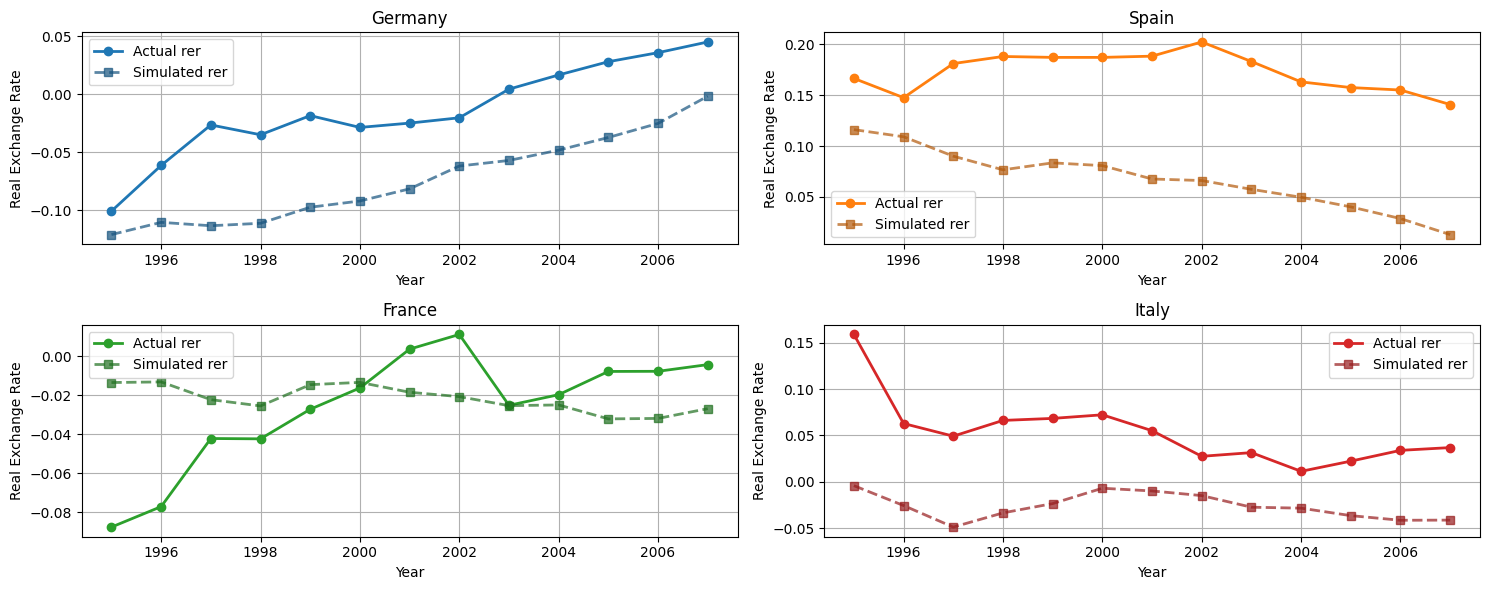

In [576]:
# Visualising 
colors = plt.cm.tab10(range(len(countries)))  # Using tab10 colormap for up to 10 distinct colors
actualColors = colors  # Use for actual data
simulatedColors = colors * 0.7  # Darken the colors for simulated data to distinguish

# Loop through each country to create subplots
fig7, axs = plt.subplots(2, 2, figsize=(15, 6))  
axs = axs.flatten()  # Flatten to access axes in a loop

for i, country in enumerate(countries):
    axs[i].plot(year, q_real_df[country], '-o', color=actualColors[i], linewidth=2, markersize=6, label='Actual rer')
    axs[i].plot(year, q_15_df[country], '--s', color=simulatedColors[i], linewidth=2, markersize=6, label='Simulated rer')
    axs[i].set_title(country)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Real Exchange Rate')
    axs[i].legend(loc='best')
    axs[i].grid(True)
    
plt.tight_layout()
#fig7.suptitle('Figure 4: Actual vs. Simulated Real Exchange Rates Relative to EU15 using labor wedge', fontsize=16, y=1.02)
plt.show()

fig7.savefig('rer_lwedge.pdf', dpi=200)
### slightly different colors 

In [577]:
# Show that resulst from the two equations are slightly different 

# mean for each data frame
q_13_mean = q_13_df.mean()
q_15_mean = q_15_df.mean()

# Combining the means into a single DataFrame 
mean_q_df = pd.DataFrame({'q using rucl': q_13_mean, 'q using l_wedge': q_15_mean})
# adding row for difference 
mean_q_df['delta'] = mean_q_df['q using rucl'] - mean_q_df['q using l_wedge']

print(mean_q_df.T)

#save to latex 
# Convert the DataFrame to a LaTeX string
mean_q_latex = mean_q_df.to_latex(float_format="%.4f", label="tab:means_differences")

# Write the LaTeX string to a file
with open('mean_comparison_1.tex', 'w') as f:
    f.write(mean_q_latex)




                  Germany     Spain    France     Italy
q using rucl    -0.080799  0.069634 -0.024790 -0.026801
q using l_wedge -0.073809  0.067674 -0.021776 -0.026466
delta           -0.006990  0.001960 -0.003015 -0.000336


Bar chart 

In [578]:
# Disected Visualisation 
# Defining 

simulated_exchange_rate_15 = {
    country: q_15_df[country]
    for country in q_15_df.columns
}

# Calculate the contributions for each country
components_df_15 = {}

for country in countries:
    # Calculate each component's contribution
    l_wedge_contribution = coef_2 * (l_wedge_df[country])
    traded_goods_contribution_15 = coef_0 * (tt2b_df[country])  
    non_traded_goods_contribution_15 = - coef_1 * (tn2b_df[country])  

    # Combine contributions into a DataFrame
    components_df_15[country] = pd.DataFrame({
        'lw': l_wedge_contribution,
        'a_T': traded_goods_contribution_15,
        'a_N': non_traded_goods_contribution_15
    }, index=l_wedge_df.index)


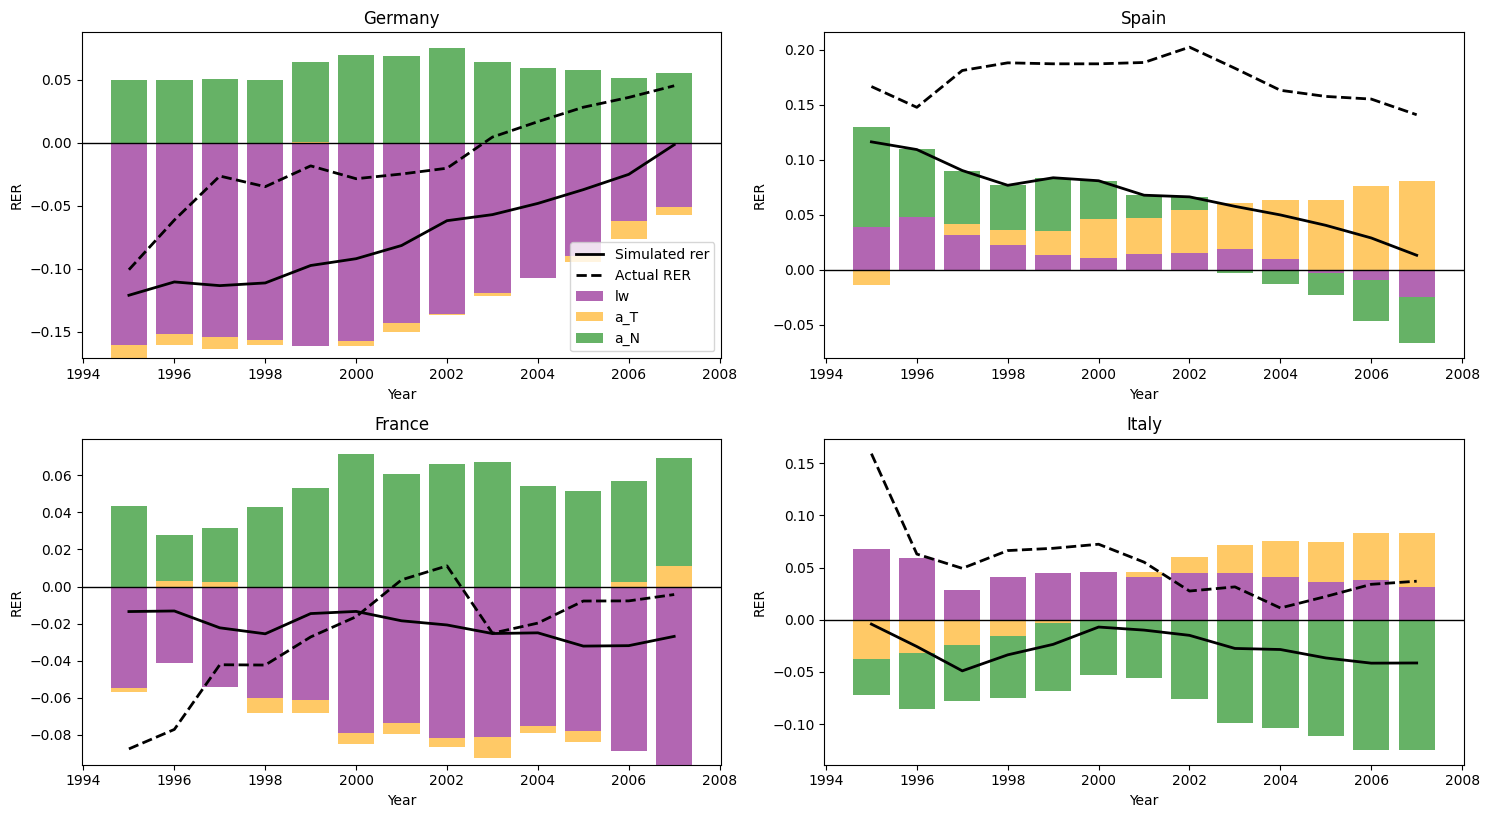

In [579]:
# Set consistent colors for each variable
variable = ['lw', 'a_T', 'a_N']
colors = {'lw': 'purple', 'a_T': 'orange', 'a_N': 'green'}

fig8, axs = plt.subplots(2, 2, figsize=(15, 9))  
axs = axs.flatten()  # Flatten the 2x2 array of axes into a 1D array for easy iteration

# Loop through countries and variables to create the plots
for i, country in enumerate(countries):
    bars_pos = np.maximum(components_df_15[country], 0)  # Positive parts of the bars
    bars_neg = np.minimum(components_df_15[country], 0)  # Negative parts of the bars

    bottoms_pos = np.zeros_like(bars_pos['lw'])  # Start bottoms at 0 for positive bars
    bottoms_neg = np.zeros_like(bars_neg['lw'])  # Start bottoms at 0 for negative bars
    
    # Plot each positive component as a stacked bar with consistent colors
       # Plot positive bars
    for v in variable:
            if i == 0:  # Only add labels for the first country
                axs[i].bar(df.index, bars_pos[v], bottom=bottoms_pos, color=colors[v], label=v, alpha=0.6) # change variable list to change 
            else:
                axs[i].bar(df.index, bars_pos[v], bottom=bottoms_pos, color=colors[v], alpha=0.6)
            bottoms_pos += bars_pos[v].values  # Update bottoms for stacking

        # Plot negative bars
    for v in variable:
            axs[i].bar(df.index, bars_neg[v], bottom=bottoms_neg, color=colors[v], alpha=0.6)
            bottoms_neg += bars_neg[v].values
    
    # Plot the simulated exchange rate
    axs[i].plot(components_df_15[country].index, simulated_exchange_rate_15[country], c='black', label='Simulated rer' if i == 0 else "", ls='-', lw=2)
    # axs[i].plot(components_df_15[country].index, q_real_df[country], c='grey', label='Simulated' if i == 0 else "", ls='--', lw=2.5) 
    axs[i].plot(df.index, q_real_df[country], 'black', label='Actual RER' if i == 0 else "", ls='--', lw=2)   

    # Setting the labels and title for each subplot
    axs[i].set_title(country)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('RER')
    axs[i].axhline(y=0, linewidth=1, color="black")

    # Add legend to the first subplot only to avoid duplication
    if i == 0:
        axs[i].legend()

# Adjust layout to prevent subplot titles and axis labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # The rect parameter may need adjustment based on your figure's specifics

# Set a common title for all subplots
#plt.suptitle('Variable Contributions to Simulated Exchange Rate Over Time', fontsize=16)

# Show the plot
plt.show() 

fig8.savefig('figure_8.pdf', dpi=200)


Correlation coeffcients

In [580]:
# Correlarion 
# Calculating the correlation for each pair
correlation_g_15 = np.corrcoef(q_real_df['Germany'], q_15_df['Germany'])[0, 1]
correlation_s_15 = np.corrcoef(q_real_df['Spain'], q_15_df['Spain'])[0, 1]
correlation_f_15 = np.corrcoef(q_real_df['France'], q_15_df['France'])[0, 1]
correlation_i_15 = np.corrcoef(q_real_df['Italy'], q_15_df['Italy'])[0, 1]


# Creating a DataFrame to display the correlations in a table
correlation_table_3 = pd.DataFrame({
    'Country': ['Germany', 'Spain', 'France', 'Italy'],
    'Correlation': [correlation_g_15, correlation_s_15, correlation_f_15, correlation_i_15]
})

# Print the correlation table
print(correlation_table_3)  

# save to latex
correlation_table_3 = correlation_table_3.to_latex(index=False, label="tab:correlation")
with open('corr_table_3.tex', 'w') as f:
    f.write(correlation_table_3)

   Country  Correlation
0  Germany     0.904059
1    Spain     0.334433
2   France    -0.491811
3    Italy     0.549151


Regression Analysis

In [581]:
# Reshape the dependent variable to match
Y = q_real_df.stack().values

# Prepare data for analysis by creating a DataFrame with named columns
data = {
    'tfp_T': tt2b_array.flatten(),
    'tfp_N': tn2b_array.flatten(),
    'l_wedge': l_wedge_array.flatten()
}
X_15 = pd.DataFrame(data)

# Add a constant term to the independent variables for the intercept
X_15 = sm.add_constant(X_15)

# Fit the OLS model
model15 = sm.OLS(Y, X_15).fit()

# Print the summary
print(model15.summary())

# Save the summary to LaTeX
latex_summary_5 = model15.summary().as_latex()
with open('reg_table_5.tex', 'w') as f:
    f.write(latex_summary_5)

 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     45.93
Date:                Sun, 19 May 2024   Prob (F-statistic):           3.81e-14
Time:                        18:16:05   Log-Likelihood:                 89.520
No. Observations:                  52   AIC:                            -171.0
Df Residuals:                      48   BIC:                            -163.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0627      0.008      8.176      0.0

In [582]:
# Drop the first column to exclude the intercept for standardization
if isinstance(X_15, pd.DataFrame):
    X_15_no_intercept = X_15.iloc[:, 1:]  # exclude the first column
else:
    # Assuming X_15 is a NumPy array if the above condition fails
    X_15_no_intercept = X_15[:, 1:]

# Standardize the predictors
scaler = StandardScaler()
X_15_scaled = scaler.fit_transform(X_15_no_intercept)

# Re-add the constant term to the scaled matrix
X_15_scaled = sm.add_constant(X_15_scaled)

# Fit the OLS model with standardized variables
model15_standardized = sm.OLS(Y, X_15_scaled).fit()

# Extract the coefficients and variable names, excluding the intercept
coefficients_15_stand = model15_standardized.params[1:]  # Exclude the intercept
variable_names = ['Productivity Traded Sector', 'Productivity Non-Traded Sector', 'Relative Unit Labor Costs']

# Create a DataFrame with the variable names and their corresponding coefficients
data = {'Variable': variable_names, 'Coefficient': coefficients_15_stand}
coefficients_15_stand_df = pd.DataFrame(data)
print(coefficients_15_stand_df)

# Convert the DataFrame to a LaTeX string
coefficients_15_stand_latex = coefficients_15_stand_df.to_latex(index=False, caption="Standardized Regression Coefficients", label="tab:standardized_regression_coeffs")

# Write the LaTeX string to a file
with open('stand_coef_3.tex', 'w') as f:
    f.write(coefficients_15_stand_latex)



                         Variable  Coefficient
0      Productivity Traded Sector     0.039290
1  Productivity Non-Traded Sector    -0.058520
2       Relative Unit Labor Costs     0.085171


In [583]:

# # Compute time averages, directly using country names as DataFrame index
# averages = {
#     'q_real_avg': q_real_df.mean(),  # Modify slicing as per actual data
#     'tt2b_avg': tt2b_df.mean(),
#     'tn2b_avg': tn2b_df.mean(),
#     'l_wedge_avg': l_wedge_df.mean()
# }

# # Create a DataFrame from the dictionary
# avg_df = pd.DataFrame(averages)
# #removove irrrelevant rows
# avg_df = avg_df.iloc[:-3]
# print(avg_df)

# # Regression analysis
# X = avg_df[['tt2b_avg', 'tn2b_avg', 'l_wedge_avg']]  # Independent variables
# Y = avg_df['q_real_avg']  # Dependent variable
# X = sm.add_constant(X)  # Add a constant to the model

# model = sm.OLS(Y, X).fit()
# print(model.summary())
#cross-sectional not possible



In [584]:
# Panel Regression 
# Prepare the data for Panel Analysis
# create a MultiIndex for the panel data structure
multi_index = pd.MultiIndex.from_product([countries, year], names=['country', 'year'])
panel_df = pd.DataFrame(index=multi_index)

# Unstack dataframes to have years as columns for each country, then stack them back with multi-level index
l_wedge_panel = l_wedge_df.unstack().reindex(panel_df.index) 
tt2b_panel = tt2b_df.unstack().reindex(panel_df.index)
tn2b_panel = tn2b_df.unstack().reindex(panel_df.index)
q_real_panel = q_real_df.unstack().reindex(panel_df.index)

# Convert unstacked DataFrame back to stacked format and add to panel_df
panel_df['l_wedge'] = l_wedge_panel
panel_df['tfp_T'] = tt2b_panel
panel_df['tfp_N'] = tn2b_panel
panel_df['Q_Real'] = q_real_panel

# Convert panel_df to a PanelData format expected by linearmodels
panel_df = panel_df.reset_index()
panel_df = panel_df.set_index(['country', 'year'])
#print(panel_df)

# Running Fixed Effects model
fe_model = PanelOLS.from_formula('Q_Real ~ tfp_T + tfp_N + l_wedge + EntityEffects', data=panel_df)
fe_results_15 = fe_model.fit()

print(fe_results_15)

#save to latex
latex_summary_6 = fe_results_15.summary.as_latex()
with open('reg_table_6.tex', 'w') as f:
    f.write(latex_summary_6)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 Q_Real   R-squared:                        0.3079
Estimator:                   PanelOLS   R-squared (Between):              0.2491
No. Observations:                  52   R-squared (Within):               0.3079
Date:                Sun, May 19 2024   R-squared (Overall):              0.2552
Time:                        18:16:05   Log-likelihood                    115.81
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.6723
Entities:                           4   P-value                           0.0008
Avg Obs:                       13.000   Distribution:                    F(3,45)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             6.6723
                            

In [585]:

# Define the model formula
formula = 'Q_Real ~ 1 + tfp_T + tfp_N + l_wedge'

# Create a model object for random effects
model = RandomEffects(panel_df['Q_Real'], panel_df[['tfp_T', 'tfp_N', 'l_wedge']])
results = model.fit()

# Print the results
print(results.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 Q_Real   R-squared:                        0.4109
Estimator:              RandomEffects   R-squared (Between):              0.5295
No. Observations:                  52   R-squared (Within):               0.0592
Date:                Sun, May 19 2024   R-squared (Overall):              0.4803
Time:                        18:16:05   Log-likelihood                    84.174
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      11.393
Entities:                           4   P-value                           0.0000
Avg Obs:                       13.000   Distribution:                    F(3,49)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             11.393
                            

### 3.3 Bilateral RERs relative to Germany

In [586]:
# BILATERAL EXCHANGE RATES - using labor wedge 

# Bilateral exchange rates using eqution 15/8
q_15_sg = coef_0 * (tt2b_df['Spain'] - tt2b_df['Germany']) - coef_1 * (tn2b_df['Spain'] - tn2b_df['Germany']) + coef_2 * (l_wedge_df['Spain'] - l_wedge_df['Germany'])
q_15_fg = coef_0 * (tt2b_df['France'] - tt2b_df['Germany']) - coef_1 * (tn2b_df['France'] - tn2b_df['Germany']) + coef_2 * (l_wedge_df['France'] - l_wedge_df['Germany'])
q_15_ig = coef_0 * (tt2b_df['Italy'] - tt2b_df['Germany']) - coef_1 * (tn2b_df['Italy'] - tn2b_df['Germany']) + coef_2 * (l_wedge_df['Italy'] - l_wedge_df['Germany'])

Visualisations

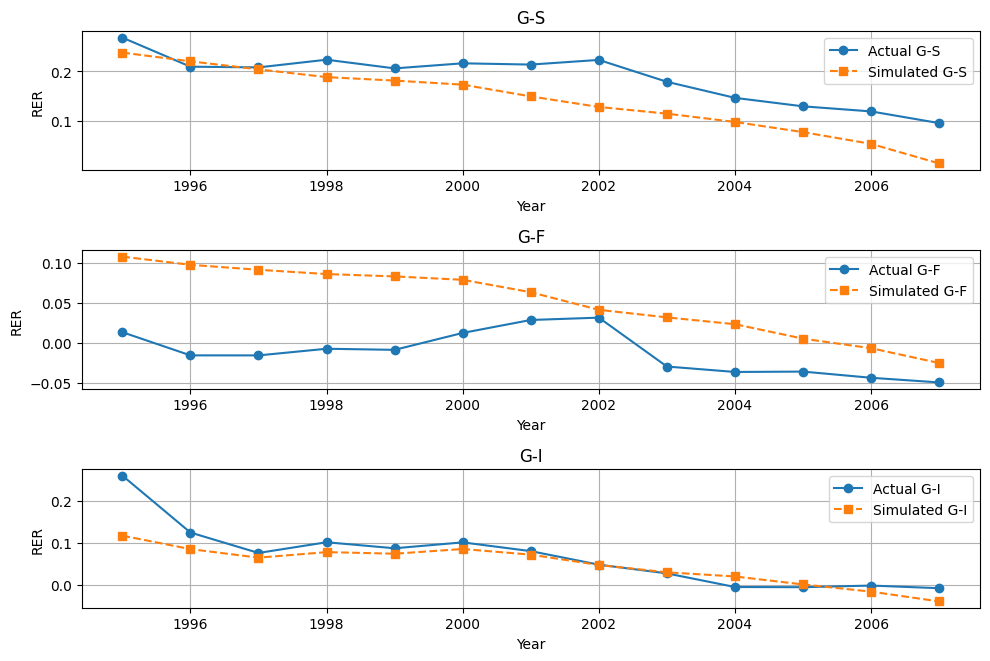

In [587]:
# Define the data and labels for bilateral exchange rates
bilat_data_15 = [
    (bilat_rate_germany_spain["bilat"], q_15_sg, 'G-S'),
    (bilat_rate_germany_france["bilat"], q_15_fg, 'G-F'),
    (bilat_rate_germany_italy["bilat"], q_15_ig, 'G-I')
]

fig9, axs = plt.subplots(3, 1, figsize=(10, 7))

# Loop through the bilateral data to create each subplot
for i, (actual_data, simulated_data, label) in enumerate(bilat_data_15): # What is going on here?
    axs[i].plot(year, actual_data, '-o', label=f'Actual {label}')
    axs[i].plot(year, simulated_data, '--s', label=f'Simulated {label}') # simulated_data??
    axs[i].set_title(label)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('RER')
    axs[i].legend()
    axs[i].grid(True)


#fig9.suptitle('Figure 3: Actual vs. Simulated Bilateral Real Exchange Rates (using the labor wedge)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig9.savefig('bilat_lwedge.pdf')

In [588]:
# Show that the data is again slightly different than using rucl 

# Create a dictionary to structure the DataFrame
data = {
    'G-S': [q_sg.mean(), q_15_sg.mean()],
    'G-F': [q_fg.mean(), q_15_fg.mean()],
    'G-I': [q_ig.mean(), q_15_ig.mean()]
}

# Row labels
index = ['q using rucl', 'q using lw']  

# Create DataFrame
exchange_rate_df = pd.DataFrame(data, index=index)

# Transpose the DataFrame to switch rows and columns
exchange_rate_df = exchange_rate_df.T

# Calculate the difference between 'using rucl' and 'using lw'
exchange_rate_df['delta'] = exchange_rate_df['q using rucl'] - exchange_rate_df['q using lw']
exchange_rate_df = exchange_rate_df.T

# Display the DataFrame
print(exchange_rate_df)

# Convert the DataFrame to a LaTeX string
mean_q_latex_2 = exchange_rate_df.to_latex(float_format="%.4f", label="tab:means_differences")

# Write the LaTeX string to a file
with open('mean_comparison_2.tex', 'w') as f:
    f.write(mean_q_latex_2)



                   G-S       G-F       G-I
q using rucl  0.150433  0.056008  0.053998
q using lw    0.141483  0.052033  0.047343
delta         0.008950  0.003976  0.006655


Bar chart

In [589]:
# Disected Visualization: Bar plot 
# Disected Visualisation 
# Defining 
variables_15 = ['lw', 'a_T', 'a_N']
# Calculate the contributions for each country
components_bilat_15_df = {}

for country in countries:
    # Calculate each component's contribution
    lwedge_contribution_bilat_15 = coef_2 * (l_wedge_df[country]-l_wedge_df['Germany'])
    traded_goods_contribution_bilat_15 = coef_0 * (tt2b_df[country]- tt2b_df['Germany'])  
    non_traded_goods_contribution_bilat_15 = - coef_1 * (tn2b_df[country] - tn2b_df['Germany']) 

    # Combine contributions into a DataFrame
    components_bilat_15_df[country] = pd.DataFrame({
        'lw': lwedge_contribution_bilat_15,
        'a_T': traded_goods_contribution_bilat_15,
        'a_N': non_traded_goods_contribution_bilat_15
    }, index=rucl_df.index)

# Remove 'Germany' from the dictionary if it exists
if 'Germany' in components_bilat_15_df:
    del components_bilat_15_df['Germany']

#print(components_bilat_df)

country_pairs = ['Spain', 'France', 'Italy']

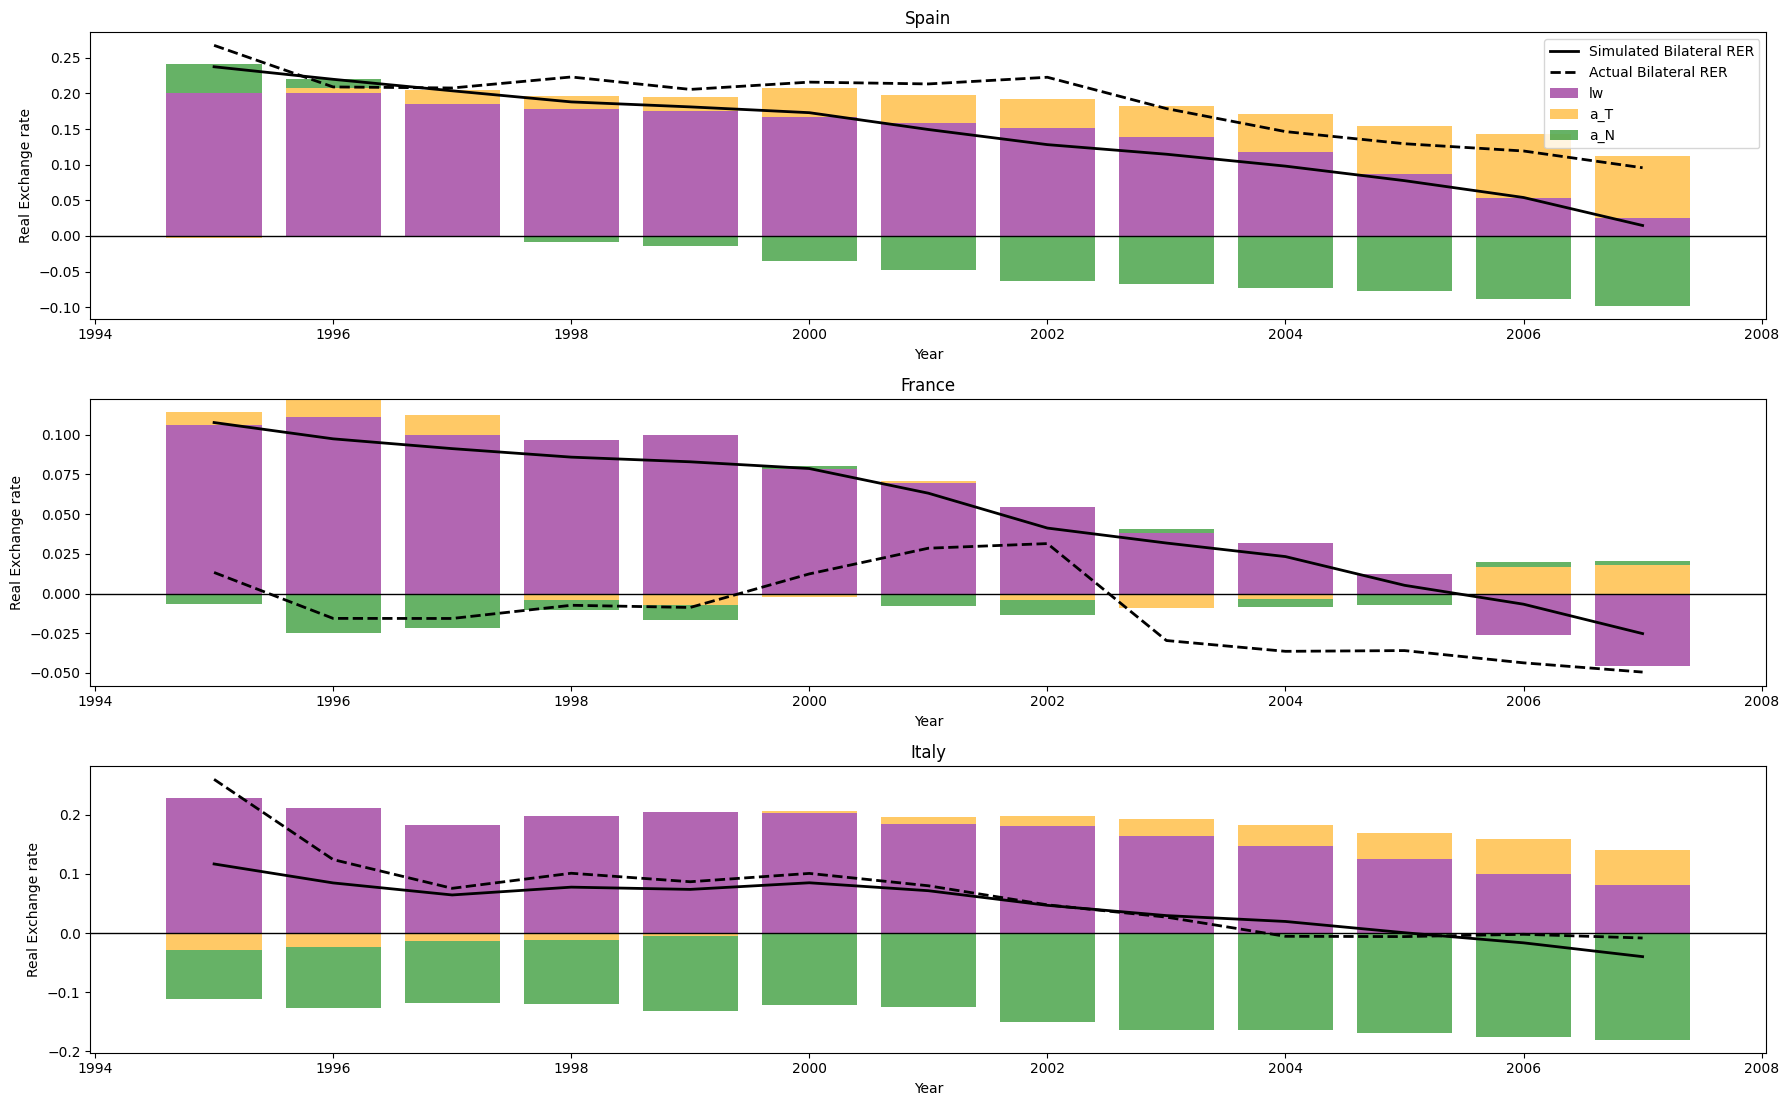

In [590]:
# Initialize plot
fig10, axs = plt.subplots(3, 1, figsize=(18, 12))
axs = axs.flatten()

# Loop through countries and variables to create the plots
for i, country in enumerate(country_pairs):
    bars_pos_15 = np.maximum(components_bilat_15_df[country], 0)
    bars_neg_15 = np.minimum(components_bilat_15_df[country], 0)
    
    bottoms_pos_15 = np.zeros(len(components_bilat_15_df[country]))
    bottoms_neg_15 = np.zeros(len(components_bilat_15_df[country]))
    
    for v in variables_15:
        if i == 0:  # Only add labels for the first subplot
            axs[i].bar(components_bilat_15_df[country].index, bars_pos_15[v], bottom=bottoms_pos_15, color=colors[v], label=v, alpha=0.6)
        else:
            axs[i].bar(components_bilat_15_df[country].index, bars_pos_15[v], bottom=bottoms_pos_15, color=colors[v], alpha=0.6)
        bottoms_pos_15 += bars_pos_15[v]
        
        axs[i].bar(components_bilat_15_df[country].index, bars_neg_15[v], bottom=bottoms_neg_15, color=colors[v], alpha=0.6)
        bottoms_neg_15 += bars_neg_15[v]

simulated_bilat_rer_15 = [q_15_sg, q_15_fg, q_15_ig]
real_bilat_rer = [bilat_rate_gs, bilat_rate_gf, bilat_rate_gi]

for i, country in enumerate(country_pairs):
    axs[i].plot(components_bilat_15_df[country].index, simulated_bilat_rer_15[i], 'k-', linewidth=2, label='Simulated Bilateral RER' if i == 0 else "")
    axs[i].plot(components_bilat_15_df[country].index, real_bilat_rer[i], 'k--', linewidth=2, label='Actual Bilateral RER' if i == 0 else "")
    
    axs[i].set_title(country)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Real Exchange rate')
    axs[i].axhline(y=0, color="black", linewidth=1)
    
    if i == 0:
        axs[i].legend()  # Only add the legend to the first subplot

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

fig10.savefig('figure_10.pdf', dpi=200)


Correlation

In [591]:
# Correlation Analysis 
# Calculating the correlation for each pair
correlation_gs_15 = np.corrcoef(bilat_rate_germany_spain["bilat"], q_15_sg)[0, 1]
correlation_gf_15 = np.corrcoef(bilat_rate_germany_france["bilat"], q_15_fg)[0, 1]
correlation_gi_15 = np.corrcoef(bilat_rate_germany_italy["bilat"], q_15_ig)[0, 1]

# Creating a DataFrame to display the correlations in a table
correlation_table_15 = pd.DataFrame({
    'Country Pair': ['Germany-Spain', 'Germany-France', 'Germany-Italy'],
    'Correlation': [correlation_gs_15, correlation_gf_15, correlation_gi_15]
})

# Print the correlation table
print(correlation_table_15) 

correlation_table_4 = correlation_table_15.to_latex(index=False, label="tab:correlation")
with open('corr_table_4.tex', 'w') as f:
    f.write(correlation_table_4)

     Country Pair  Correlation
0   Germany-Spain     0.916462
1  Germany-France     0.635672
2   Germany-Italy     0.880768


Regression analysis

In [592]:
# Create data frame for all country pairs 
#l_wedge
l_wedge_df["sg"] = l_wedge_df["Spain"]-l_wedge_df["Germany"]
l_wedge_df["fg"] = l_wedge_df["France"]-l_wedge_df["Germany"]
l_wedge_df["ig"] = l_wedge_df["Italy"]-l_wedge_df["Germany"]

In [593]:
# Create Dataset for each Country
temp_france2 = bilat_rate_germany_france
temp_france2["l_wedge"] = l_wedge_df["fg"]
temp_france2["tfp_T"] = tt2b_df["fg"]
temp_france2["tfp_N"] = tn2b_df["fg"]

temp_spain2 = bilat_rate_germany_spain
temp_spain2["l_wedge"] = l_wedge_df["sg"]
temp_spain2["tfp_T"] = tt2b_df["sg"]
temp_spain2["tfp_N"] = tn2b_df["sg"]

temp_italy2 = bilat_rate_germany_italy
temp_italy2["l_wedge"] = l_wedge_df["ig"]
temp_italy2["tfp_T"] = tt2b_df["ig"]
temp_italy2["tfp_N"] = tn2b_df["ig"]

# Append all 3 datasets
all_countries_15 = pd.concat([temp_france2, temp_spain2, temp_italy2])
print(bilat_rate_germany_france)

             0     bilat country   l_wedge     tfp_T     tfp_N
1995  0.013258  0.013258  France  0.457091  0.027205  0.008491
1996 -0.015666 -0.015666  France  0.478412  0.038290  0.032867
1997 -0.015713 -0.015713  France  0.430996  0.043124  0.028334
1998 -0.007406 -0.007406  France  0.415757 -0.013785  0.008741
1999 -0.008780 -0.008780  France  0.429406 -0.024963  0.012490
2000  0.012349  0.012349  France  0.338164 -0.006474 -0.002760
2001  0.028526  0.028526  France  0.299967  0.005112  0.010530
2002  0.031443  0.031443  France  0.234449 -0.013692  0.012171
2003 -0.029606 -0.029606  France  0.164654 -0.030829 -0.003398
2004 -0.036401 -0.036401  France  0.137328 -0.011269  0.007051
2005 -0.035937 -0.035937  France  0.052592 -0.003491  0.007958
2006 -0.043657 -0.043657  France -0.113867  0.056509 -0.004192
2007 -0.049476 -0.049476  France -0.195594  0.060603 -0.003227


In [594]:
# Create Regression Model
import statsmodels.formula.api as smf

mod = smf.ols(formula='bilat ~ tfp_T + tfp_N + l_wedge', data=all_countries_15)
res_15 = mod.fit()
print(res_15.summary())

#save to latex
latex_summary_7 = res_15.summary().as_latex()
with open('reg_table_7.tex', 'w') as f:
    f.write(latex_summary_7)


                            OLS Regression Results                            
Dep. Variable:                  bilat   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     43.06
Date:                Sun, 19 May 2024   Prob (F-statistic):           7.70e-12
Time:                        18:16:07   Log-Likelihood:                 65.817
No. Observations:                  39   AIC:                            -123.6
Df Residuals:                      35   BIC:                            -117.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0721      0.018     -4.046      0.0

In [595]:
# Standardization

# Create a copy of the data to standardize
all_countries_15_standardized = all_countries_15.copy()

# List of columns to standardize
columns_to_standardize = ['tfp_T', 'tfp_N', 'l_wedge', 'bilat']

# Standardizing each column
scaler = StandardScaler()
all_countries_15_standardized[columns_to_standardize] = scaler.fit_transform(all_countries_15_standardized[columns_to_standardize])

# Create the OLS model using standardized data
mod_standardized = smf.ols(formula='bilat ~ tfp_T + tfp_N + l_wedge', data=all_countries_15_standardized)
res_15_standardized = mod_standardized.fit()

# Save the table to LaTeX
coefficients = res_15_standardized.params[1:]  # Skipping the intercept
coefficients_df = pd.DataFrame({
    'Variable': coefficients.index,
    'Coefficient': coefficients.values
})
print(coefficients_df)
# Convert the DataFrame to a LaTeX string
coefficients_latex = coefficients_df.to_latex(index=False, caption="Standardized Regression Coefficients", label="tab:standardized_coeffs")

# Write the LaTeX string to a file
with open('stand_coef_4.tex', 'w') as f:
    f.write(coefficients_latex)


  Variable  Coefficient
0    tfp_T     0.583154
1    tfp_N    -0.620594
2  l_wedge     1.007031


In [596]:
# Panel Regression 

# Create a copy of the DataFrame and set the index
all_countries_15_copy = all_countries_15.copy()
all_countries_15_copy.set_index('country', append=True, inplace=True)
all_countries_15_copy.index.names = ['year', 'country']

# Explicitly convert and set the 'year' part of the MultiIndex to numeric

all_countries_15_copy.reset_index(inplace=True)


# drop column
all_countries_15_copy.rename(columns={0: 'zero'}, inplace=True)

all_countries_15_copy = all_countries_15_copy.drop('zero', axis=1, inplace=False)


# Now let's set 'country' and 'year' as the index for panel data, ensuring they are in the correct order
all_countries_15_copy.set_index(['country', 'year'], inplace=True)



In [597]:
# Define and fit the panel regression model with fixed effects
mod = PanelOLS.from_formula('bilat ~ tfp_T + tfp_N + l_wedge + EntityEffects', data=all_countries_15_copy)
res_pan = mod.fit()

# Print the summary of the model
print(res_pan.summary)
# sign of tn2b is different than expected 

#save to latex
latex_summary_8 = res_pan.summary.as_latex()
with open('reg_table_8.tex', 'w') as f:
    f.write(latex_summary_8)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  bilat   R-squared:                        0.7260
Estimator:                   PanelOLS   R-squared (Between):             -0.0661
No. Observations:                  39   R-squared (Within):               0.7260
Date:                Sun, May 19 2024   R-squared (Overall):              0.0674
Time:                        18:16:07   Log-likelihood                    85.306
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      29.139
Entities:                           3   P-value                           0.0000
Avg Obs:                       13.000   Distribution:                    F(3,33)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             29.139
                            

## 4. Discussion

### Independent Variables

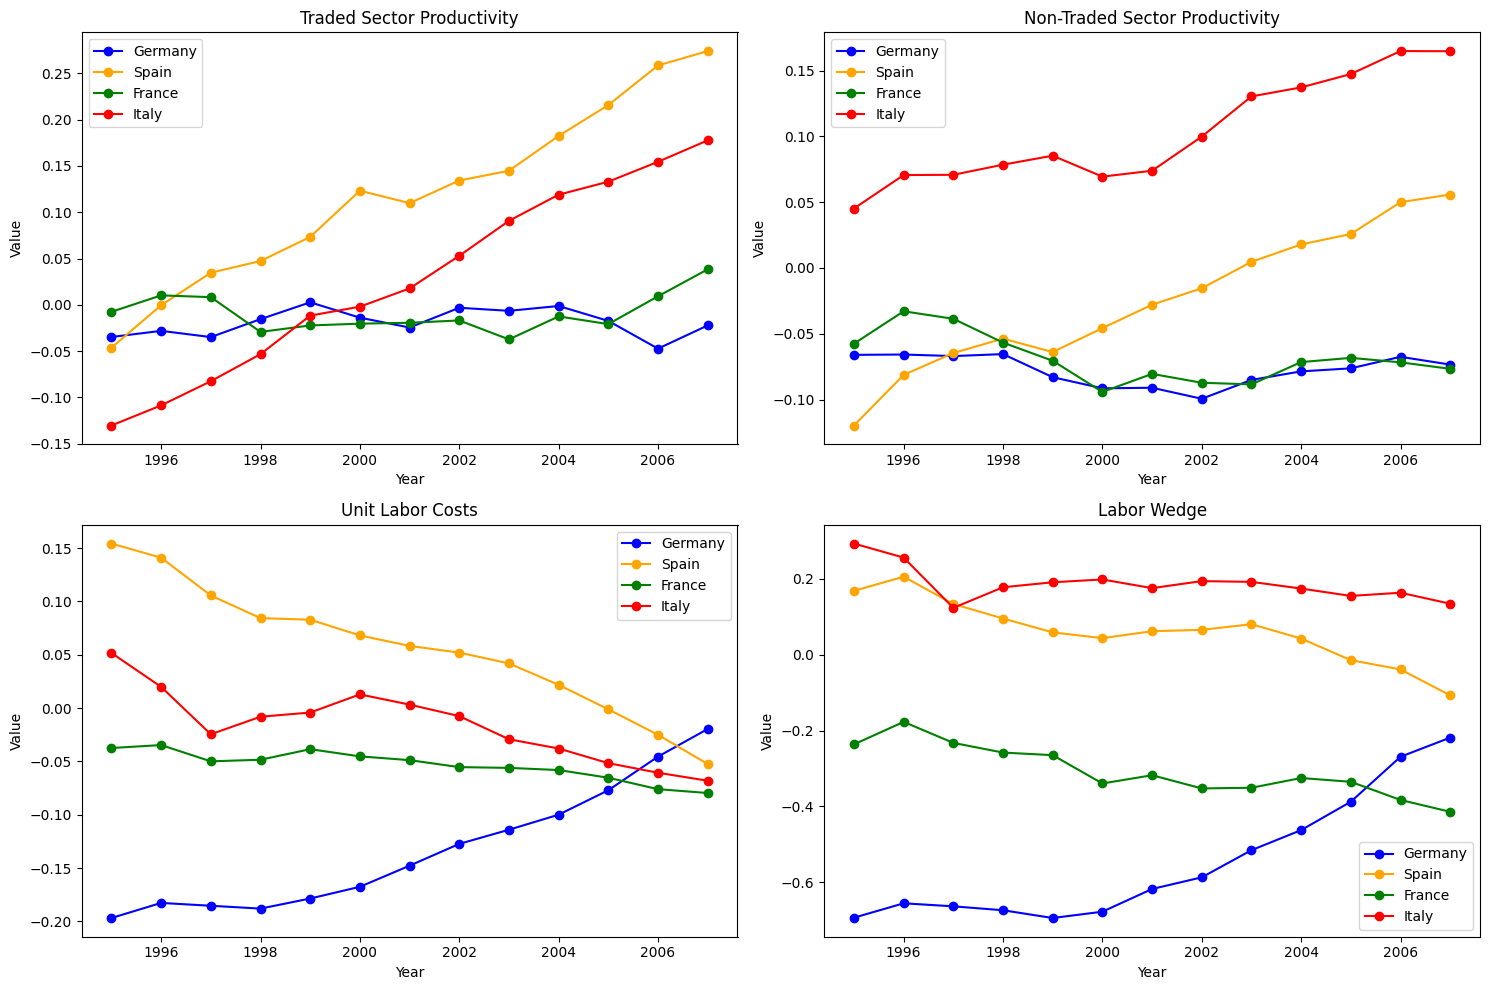

In [598]:
# Graphs of the dependent variables over time by country

import matplotlib.pyplot as plt
# Define colors for each country
colors = {'Germany': 'blue', 'Spain': 'orange', 'France': 'green', 'Italy': 'red'}

# Years for the x-axis (assuming all data frames have the same index and are time series)
years = tt2b_df.index

# Create subplots
fig11, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust dimensions as needed
axs = axs.flatten()

# Plotting
variables = [(tt2b_df, 'Traded Sector Productivity'),
             (tn2b_df, 'Non-Traded Sector Productivity'),
             (rucl_df, 'Unit Labor Costs'),
             (l_wedge_df, 'Labor Wedge')]
titles = ['Traded Sector Productivity', 'Non-Traded Sector Productivity', 'Unit Labor Costs', 'Labor Wedge']

for i, (df, title) in enumerate(variables):
    for country in colors:
        axs[i].plot(years, df[country], label=country, color=colors[country], marker='o')
    axs[i].set_title(title)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()

fig11.savefig('figure_11.pdf', dpi=200)


In [599]:
# Correlation analysis

# Preprocess DataFrames: Remove the last three columns and convert to numeric
def clean_data(df):
    return df.iloc[:, :-3].apply(pd.to_numeric, errors='coerce')

tt2b_clean = clean_data(tt2b_df)
tn2b_clean = clean_data(tn2b_df)
l_wedge_clean = clean_data(l_wedge_df)
rulc_clean = clean_data(rucl_df)

# Concatenate all cleaned DataFrames into a single DataFrame for easier analysis
full_data = pd.concat([q_real_df, tt2b_clean, tn2b_clean, l_wedge_clean, rulc_clean], axis=1, keys=['q_real', 'tfp_t', 'tfp_N', 'l_wedge', 'rulc'])

countries = q_real_df.columns

# Initialize a dictionary to store correlation matrices
country_correlations = {}

# Iterate through each country to calculate correlations
for country in countries:
    # Creating a DataFrame for each country with all variables
    data = {
        'q_real': q_real_df[country],
        'tt2b': tt2b_clean[country],
        'tn2b': tn2b_clean[country],
        'l_wedge': l_wedge_clean[country],
        'rulc': rulc_clean[country]
    }
    country_df = pd.DataFrame(data)
    
    # Calculate the correlation matrix for this country
    country_correlations[country] = country_df.corr()

# Optionally, print the correlation matrix for each country
for country, matrix in country_correlations.items():
    print(f"Correlation matrix for {country}:")
    print(matrix)
    print("\n")




Correlation matrix for Germany:
           q_real      tt2b      tn2b   l_wedge      rulc
q_real   1.000000  0.130901 -0.143670  0.854002  0.889371
tt2b     0.130901  1.000000 -0.624061 -0.210541 -0.080139
tn2b    -0.143670 -0.624061  1.000000  0.120002 -0.061585
l_wedge  0.854002 -0.210541  0.120002  1.000000  0.983234
rulc     0.889371 -0.080139 -0.061585  0.983234  1.000000


Correlation matrix for Spain:
           q_real      tt2b      tn2b   l_wedge      rulc
q_real   1.000000 -0.330470 -0.345835  0.282707  0.329856
tt2b    -0.330470  1.000000  0.980712 -0.936444 -0.989934
tn2b    -0.345835  0.980712  1.000000 -0.876324 -0.978058
l_wedge  0.282707 -0.936444 -0.876324  1.000000  0.956928
rulc     0.329856 -0.989934 -0.978058  0.956928  1.000000


Correlation matrix for France:
           q_real      tt2b      tn2b   l_wedge      rulc
q_real   1.000000 -0.084732 -0.726981 -0.822214 -0.645229
tt2b    -0.084732  1.000000  0.373476 -0.098248 -0.407484
tn2b    -0.726981  0.373476  1.00

Visualisation of Regression results

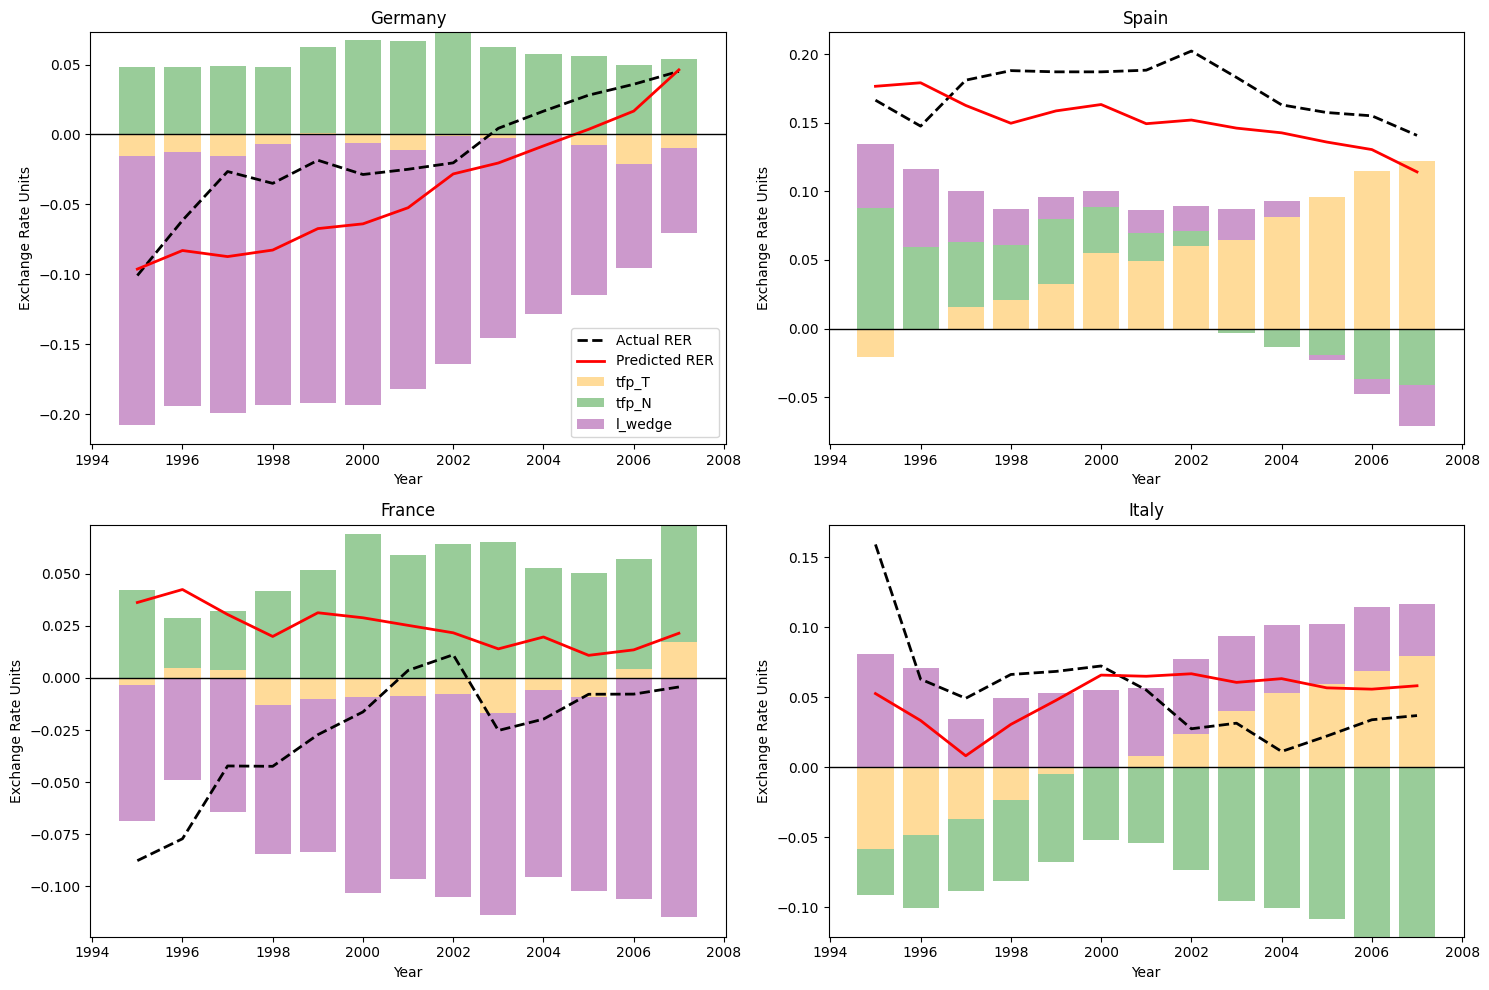

In [600]:
# Visualisation of Regression results 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Regression coefficients and intercept
coefficients = {'tfp_T': 0.4459, 'tfp_N': -0.7345, 'l_wedge': 0.2769}
intercept = 0.0627

# Calculate contributions for each variable and the predicted RER
contributions = {}
predicted_rer = {}
residuals = {}
for country in q_real_df.columns:
    contributions_df = pd.DataFrame({
        'tfp_T': coefficients['tfp_T'] * tt2b_df[country],
        'tfp_N': coefficients['tfp_N'] * tn2b_df[country],
        'l_wedge': coefficients['l_wedge'] * l_wedge_df[country]
    })
    contributions_df['predicted_rer'] = contributions_df.sum(axis=1) + intercept
    contributions[country] = contributions_df
    predicted_rer[country] = contributions_df['predicted_rer']
    residuals[country] = q_real_df[country] - predicted_rer[country]

# Plotting
fig12, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
colors = {'tfp_T': 'orange', 'tfp_N': 'green', 'l_wedge': 'purple'}

for i, country in enumerate(q_real_df.columns):
    ax = axs[i]
    df = contributions[country]
    bottoms_pos = np.zeros(len(df))
    bottoms_neg = np.zeros(len(df))

    # Positive and negative contributions
    for var in ['tfp_T', 'tfp_N', 'l_wedge']:
        pos = np.maximum(0, df[var])
        neg = np.minimum(0, df[var])
        ax.bar(df.index, pos, bottom=bottoms_pos, color=colors[var], label=var if i == 0 else "", alpha=0.4)
        ax.bar(df.index, neg, bottom=bottoms_neg, color=colors[var], alpha=0.4)
        bottoms_pos += pos
        bottoms_neg += neg

    # Plot actual and predicted RER
    ax.plot(q_real_df.index, q_real_df[country], 'k--', label='Actual RER' if i == 0 else "", linewidth=2)
    ax.plot(df.index, df['predicted_rer'], 'r-', label='Predicted RER' if i == 0 else "", linewidth=2)

    # Add residuals as another layer
    #ax.plot(df.index, residuals[country], 'm-', label='Residuals' if i == 0 else "", linewidth=1)

    ax.set_title(country)
    ax.set_xlabel('Year')
    ax.set_ylabel('Exchange Rate Units')
    ax.axhline(y=0, color="black", linewidth=1)

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

fig12.savefig('reg_model.pdf', dpi=200)


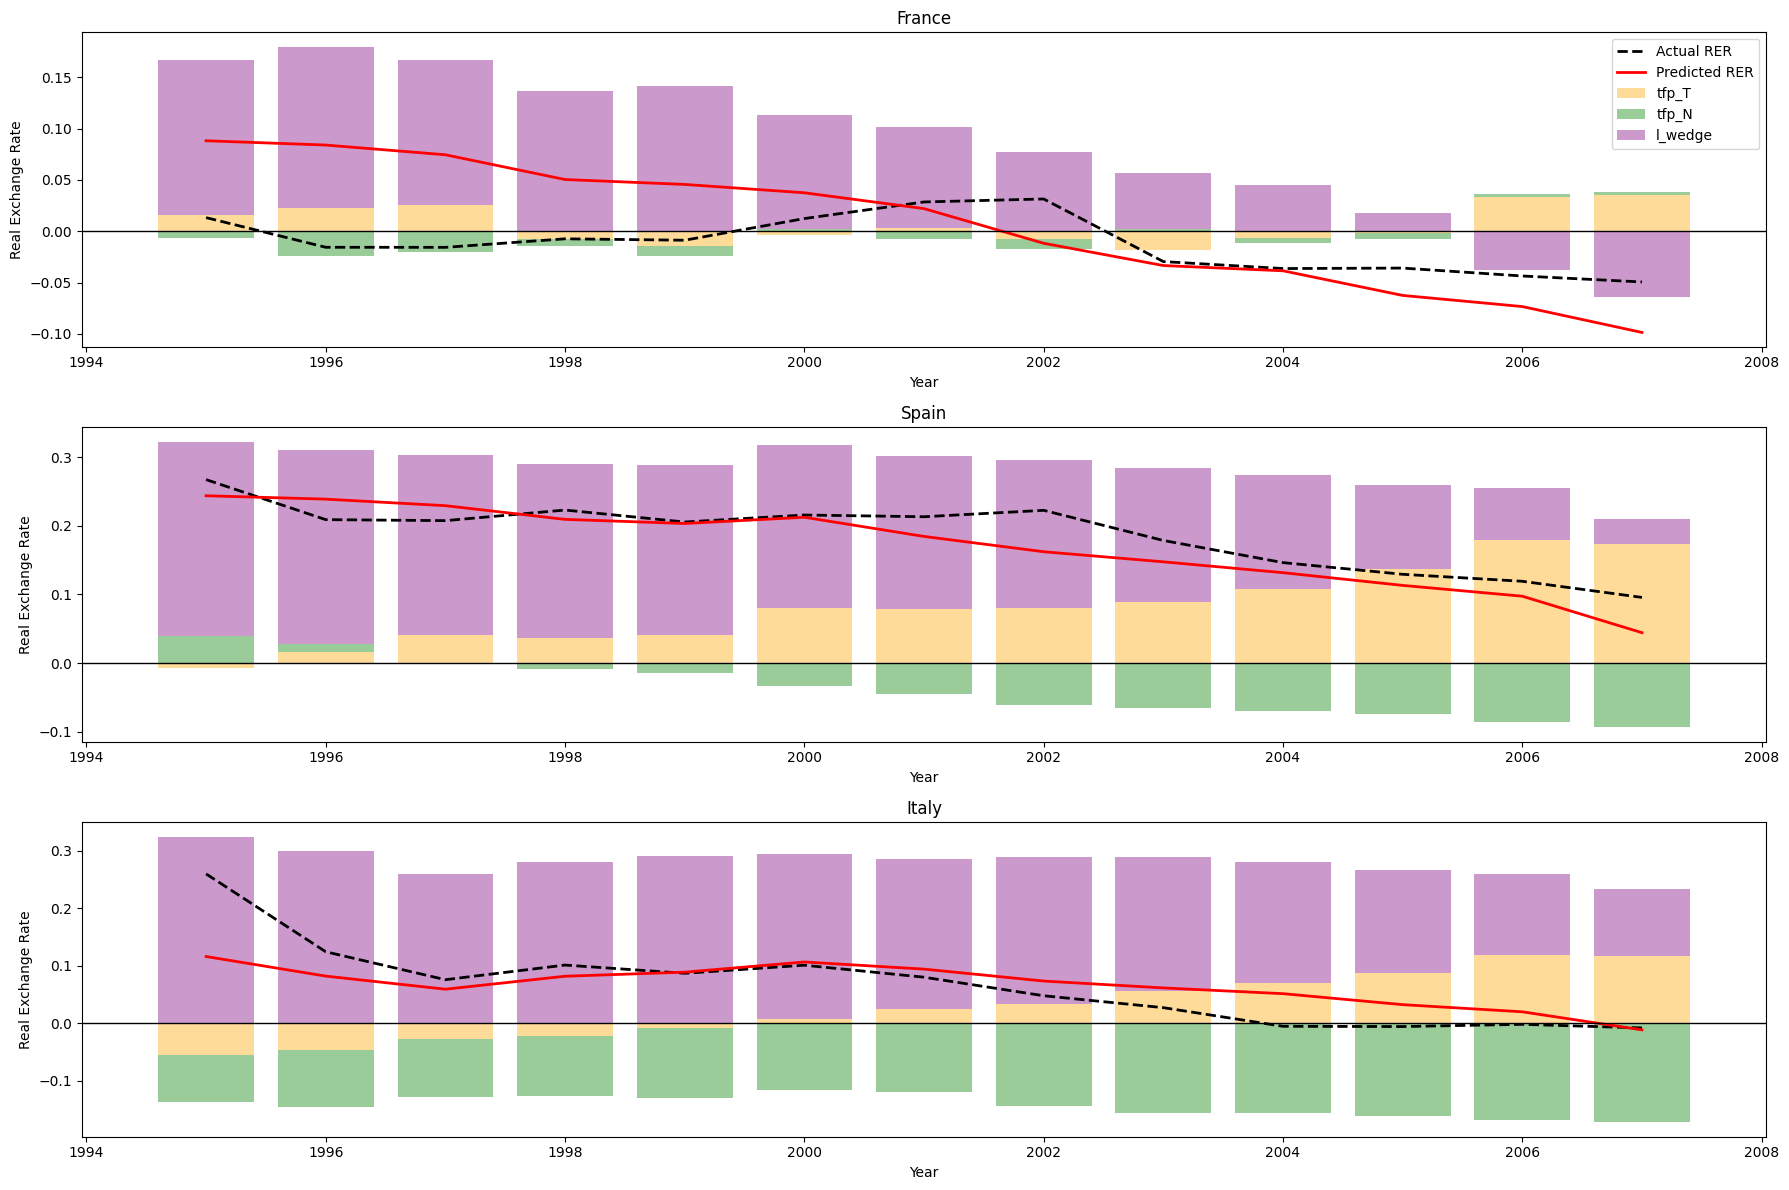

In [601]:
# Visualisation of regression result for bilat

# Define regression coefficients and intercept (assuming the DataFrame 'all_countries_15' is defined and contains relevant data)
coefficients = {'tfp_T': 0.5856, 'tfp_N': -0.7258, 'l_wedge': 0.3293}
intercept = -0.0721


# Compute the predicted bilateral real exchange rate (RER) based on the given coefficients and intercept
all_countries_15['predicted_bilat'] = intercept + all_countries_15['tfp_T'] * coefficients['tfp_T'] + all_countries_15['tfp_N'] * coefficients['tfp_N'] + all_countries_15['l_wedge'] * coefficients['l_wedge']

# Calculate contributions for each variable
for var in coefficients:
    all_countries_15[f'{var}_contribution'] = all_countries_15[var] * coefficients[var]

# print(all_countries_15.country)

# Initialize the plot
fig13, axs = plt.subplots(3, 1, figsize=(18, 12))  # Adjust based on the number of unique countries
axs = axs.flatten()

# Plotting settings
colors = {'tfp_T': 'orange', 'tfp_N': 'green', 'l_wedge': 'purple'}

for i, country in enumerate(all_countries_15['country'].unique()):
    data = all_countries_15[all_countries_15['country'] == country]

    # Plot contributions as stacked bars
    positive_bottoms = np.zeros(len(data))  # Initialize bottoms for 
    negative_bottoms = np.zeros(len(data))  
    for var, color in colors.items():
        values = data[f'{var}_contribution']
        is_positive = values >= 0
        
        axs[i].bar(data.index[is_positive], values[is_positive], bottom=positive_bottoms[is_positive], color=color, label=var if i == 0 else "", alpha=0.4)
        axs[i].bar(data.index[~is_positive], values[~is_positive], bottom=negative_bottoms[~is_positive], color=color, alpha=0.4)

        # Update bottoms for next stack
        positive_bottoms[is_positive] += values[is_positive]
        negative_bottoms[~is_positive] += values[~is_positive]

    # Plot actual and predicted RER
    axs[i].plot(data.index, data['bilat'], 'k--', label='Actual RER' if i == 0 else None, linewidth=2)
    axs[i].plot(data.index, data['predicted_bilat'], 'r-', label='Predicted RER' if i == 0 else None, linewidth=2)

    axs[i].set_title(country)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Real Exchange Rate')
    axs[i].axhline(y=0, color="black", linewidth=1)

    if i == 0:
        axs[i].legend()

plt.tight_layout()
plt.show()

fig13.savefig('reg_model_bilat.pdf', dpi=200)